# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [3]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [4]:
data.columns

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=172)

In [5]:
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')

In [6]:
data.head()

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
id,,,,,,,,,,,,,,,,,,,,,
0,109,77,65,10,81.21,221.68,3.63,32.24,96.68,2.33,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1958,0
1,109,0,145,50,0.00,30.73,31.66,0.00,25.99,30.89,...,122.08,NaN,0.0,3.96,0.0,0.0,352.91,0.00,710,0
2,109,70,120,0,56.49,99.36,0.00,53.99,82.05,0.00,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,882,0
3,109,160,240,130,76.03,95.98,53.84,68.76,78.48,50.23,...,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,982,0
4,109,290,136,122,63.26,42.94,15.76,56.99,38.11,9.63,...,35.12,0.0,0.0,0.00,0.0,390.8,308.89,213.47,647,0


Let's look at each variable's datatype:

In [7]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        69999 no

Let's also summarize the features using the df.describe method:

In [8]:
data.describe(include="all")

,circle_id,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon,churn_probability
count,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,...,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,109.0,328.139788,322.376363,323.846355,306.451436,310.572674,304.513065,198.874771,197.153383,196.543577,...,85.846074,86.348404,122.171882,128.934444,135.486541,51.773924,51.240204,50.127506,1220.639709,0.101887
std,0.0,404.211068,411.070120,426.181405,465.502866,479.131770,477.936832,316.818355,322.482226,324.089234,...,178.067280,170.297094,554.869965,554.096072,568.310234,212.513909,211.114667,213.101403,952.426321,0.302502
min,109.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-13.090000,-55.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000
25%,109.0,110.000000,100.000000,90.000000,44.780000,42.910000,38.710000,34.860000,32.240000,31.575000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000
50%,109.0,229.000000,220.000000,225.000000,145.280000,141.230000,138.360000,96.480000,91.885000,91.800000,...,8.800000,9.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000
75%,109.0,438.000000,430.000000,436.000000,374.305000,380.045000,370.895000,232.990000,227.630000,229.345000,...,122.070000,122.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000
max,109.0,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,8362.360000,7043.980000,14007.340000,...,4809.360000,3483.170000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000,1.000000


# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [9]:
data['circle_id'].unique()

array([109], dtype=int64)

In [10]:
X = data.drop(['circle_id'],axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 22), (69999,))

Splitting train and test data to avoid any contamination of the test data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 22), (14000, 22), (55999,), (14000,))

In [12]:
X_train.head()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,arpu_3g_6,...,arpu_2g_6,arpu_2g_7,arpu_2g_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
id,,,,,,,,,,,,,,,,,,,,,
57890,0,0,350,25.59,0.00,96.34,22.44,NaN,89.58,NaN,...,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,1589
6433,248,355,117,188.61,68.89,101.71,70.73,22.18,15.13,NaN,...,NaN,0.0,NaN,0.0,306.91,0.0,0.0,12.88,0.00,1358
521,586,604,946,1355.14,1311.71,2012.01,632.36,567.89,849.89,NaN,...,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,2129
4746,369,110,215,541.78,493.13,369.76,90.56,47.16,60.61,NaN,...,NaN,NaN,NaN,0.0,0.00,0.0,0.0,0.00,0.00,2967
32605,285,150,565,269.44,428.06,748.19,26.41,88.74,150.79,NaN,...,NaN,NaN,4.1,0.0,0.00,0.0,0.0,0.00,874.27,2665


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

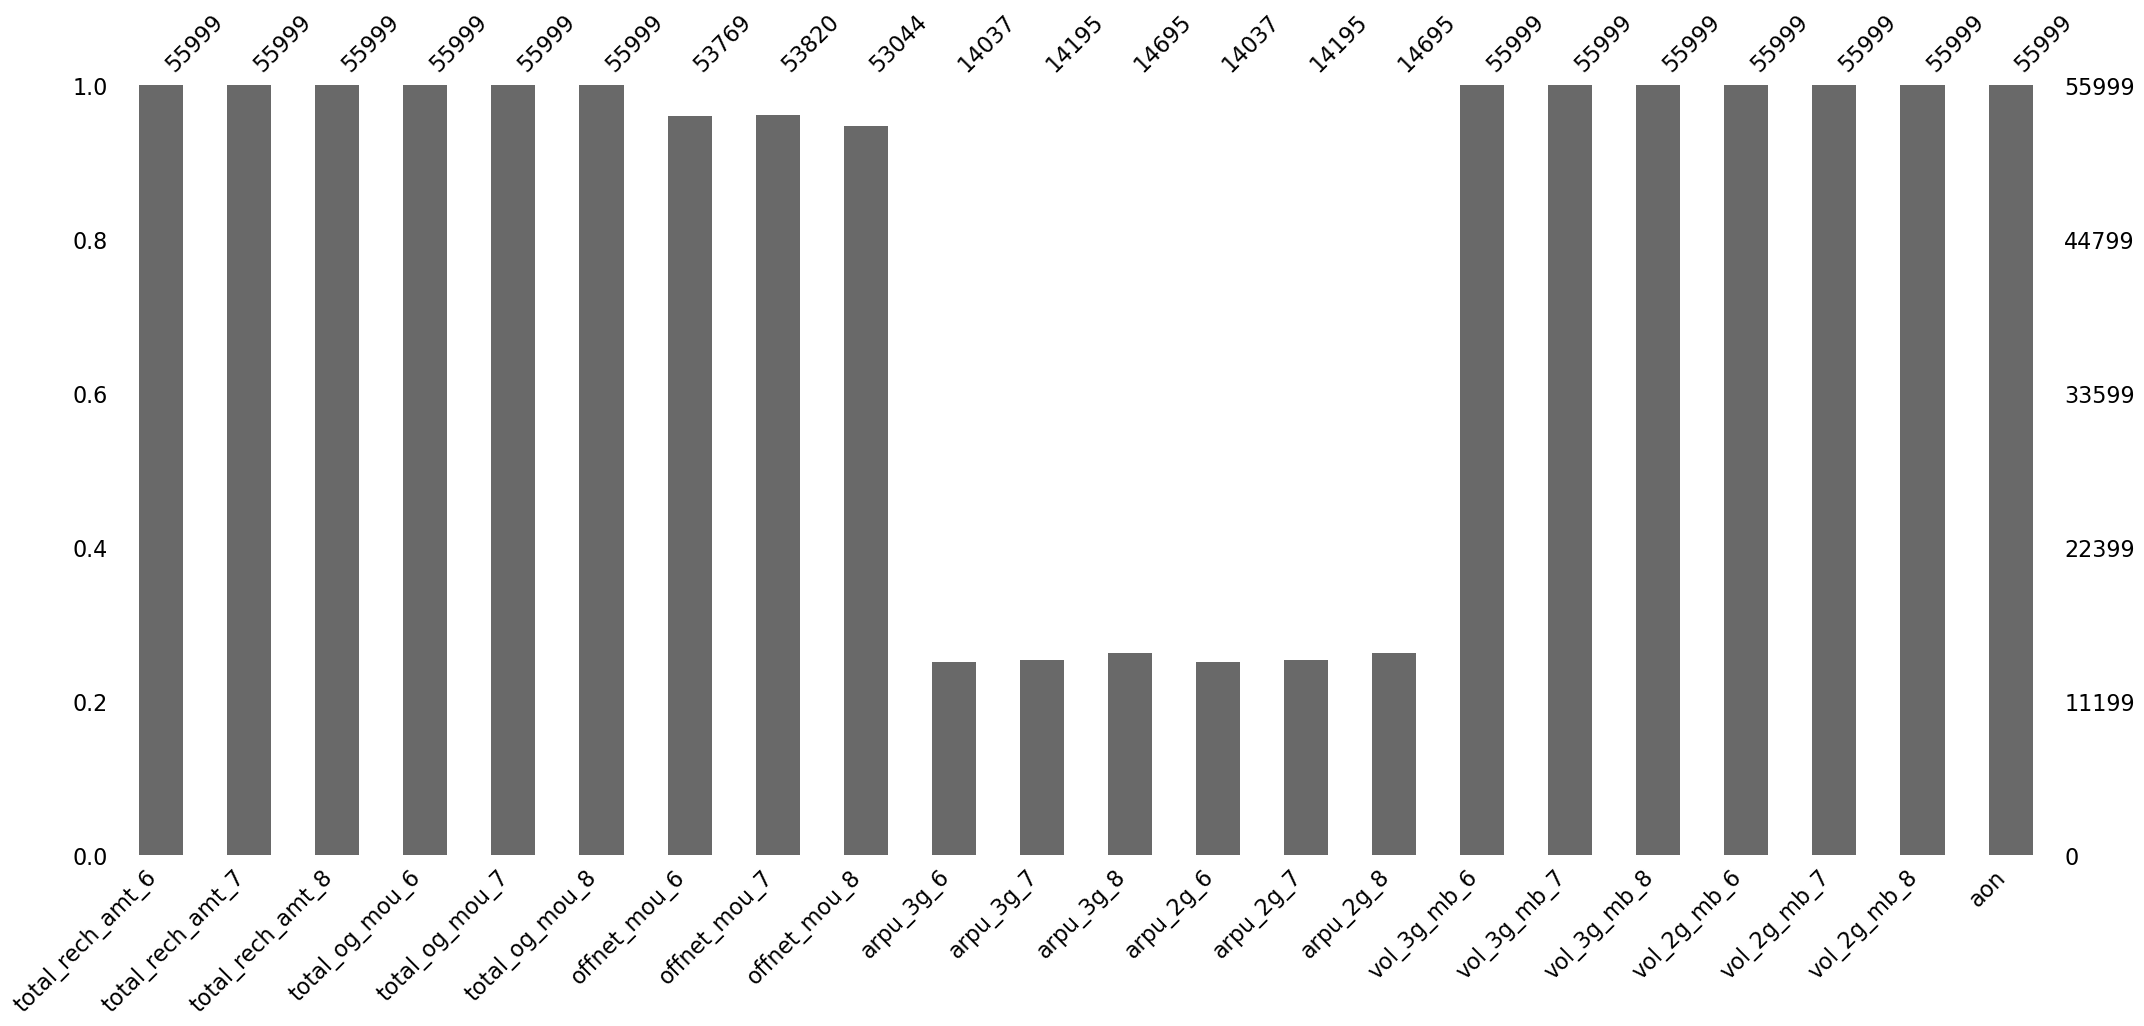

In [13]:
msno.bar(X_train)

<Axes: >

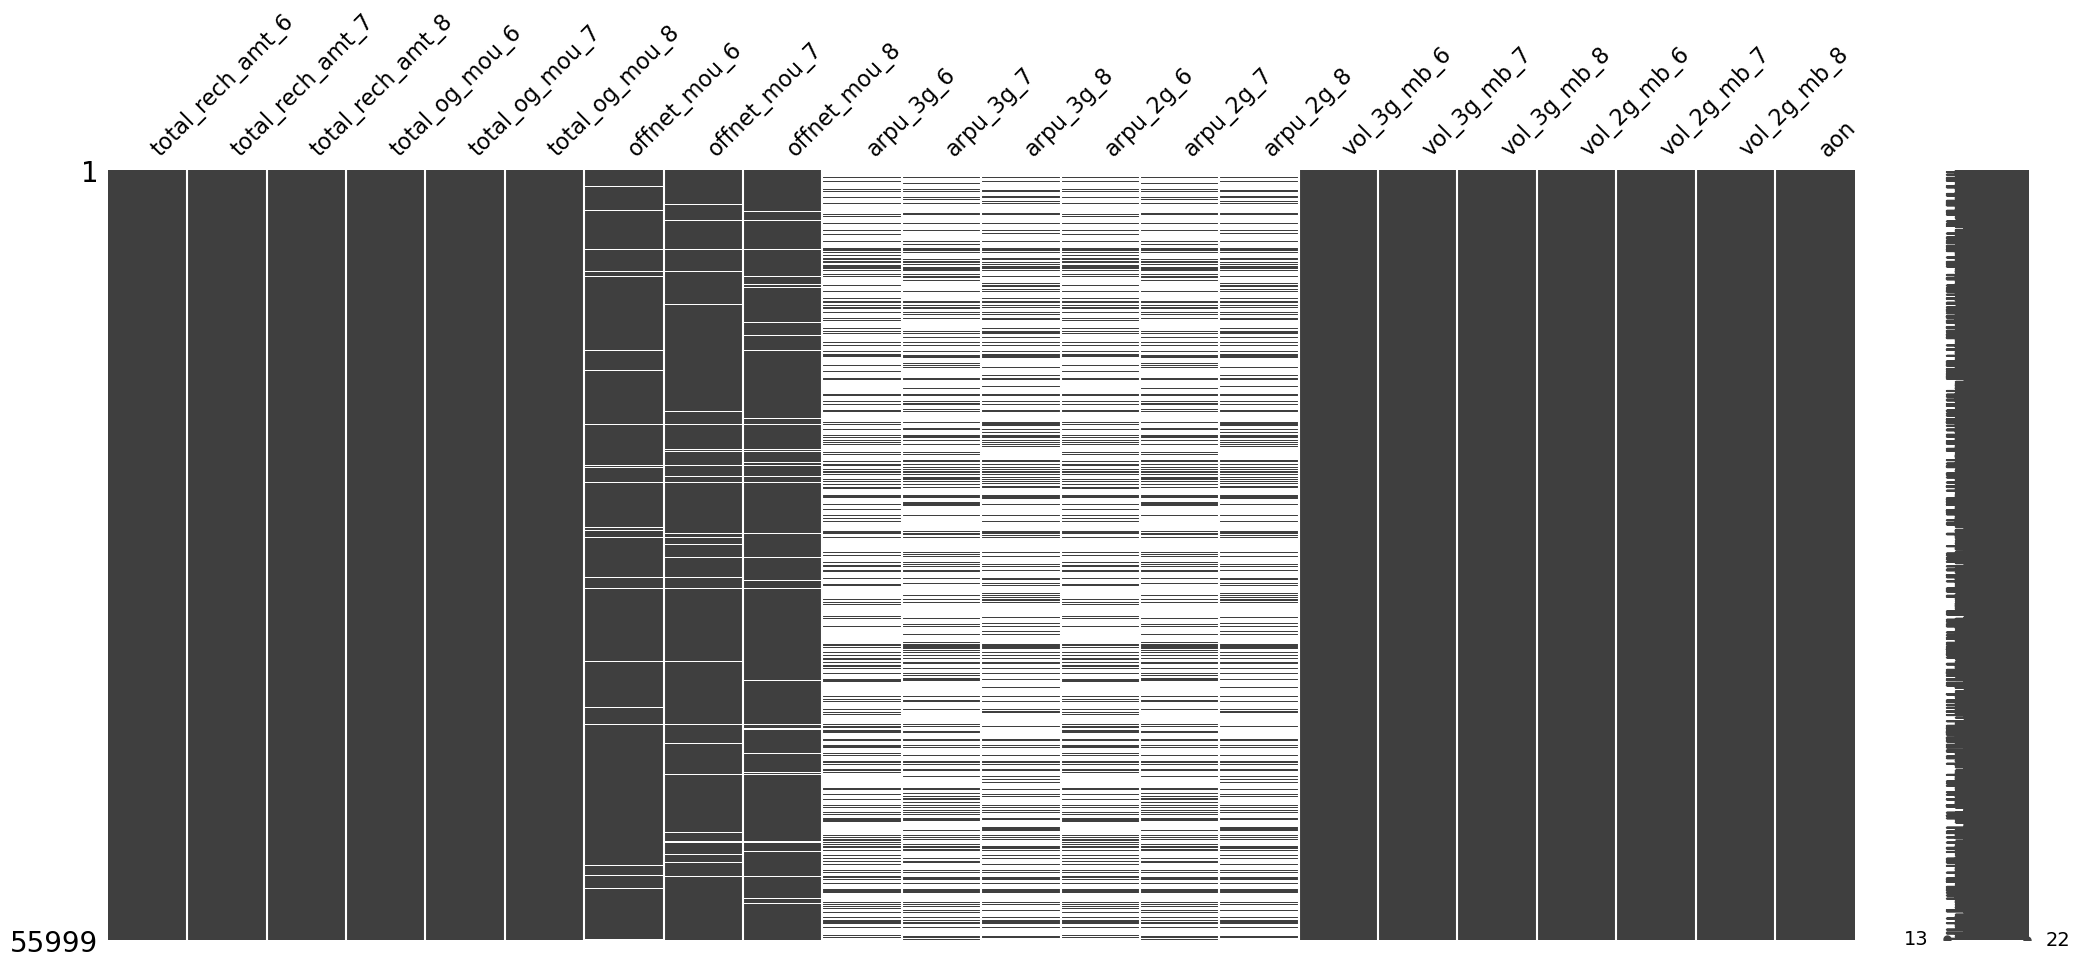

In [14]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [15]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

total_rech_amt_6     0.000000
total_rech_amt_7     0.000000
total_rech_amt_8     0.000000
total_og_mou_6       0.000000
total_og_mou_7       0.000000
total_og_mou_8       0.000000
offnet_mou_6         3.982214
offnet_mou_7         3.891141
offnet_mou_8         5.276880
arpu_3g_6           74.933481
arpu_3g_7           74.651333
arpu_3g_8           73.758460
arpu_2g_6           74.933481
arpu_2g_7           74.651333
arpu_2g_8           73.758460
vol_3g_mb_6          0.000000
vol_3g_mb_7          0.000000
vol_3g_mb_8          0.000000
vol_2g_mb_6          0.000000
vol_2g_mb_7          0.000000
vol_2g_mb_8          0.000000
aon                  0.000000
dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [16]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon'],
      dtype='object')

In [17]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 16)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [18]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

In [19]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

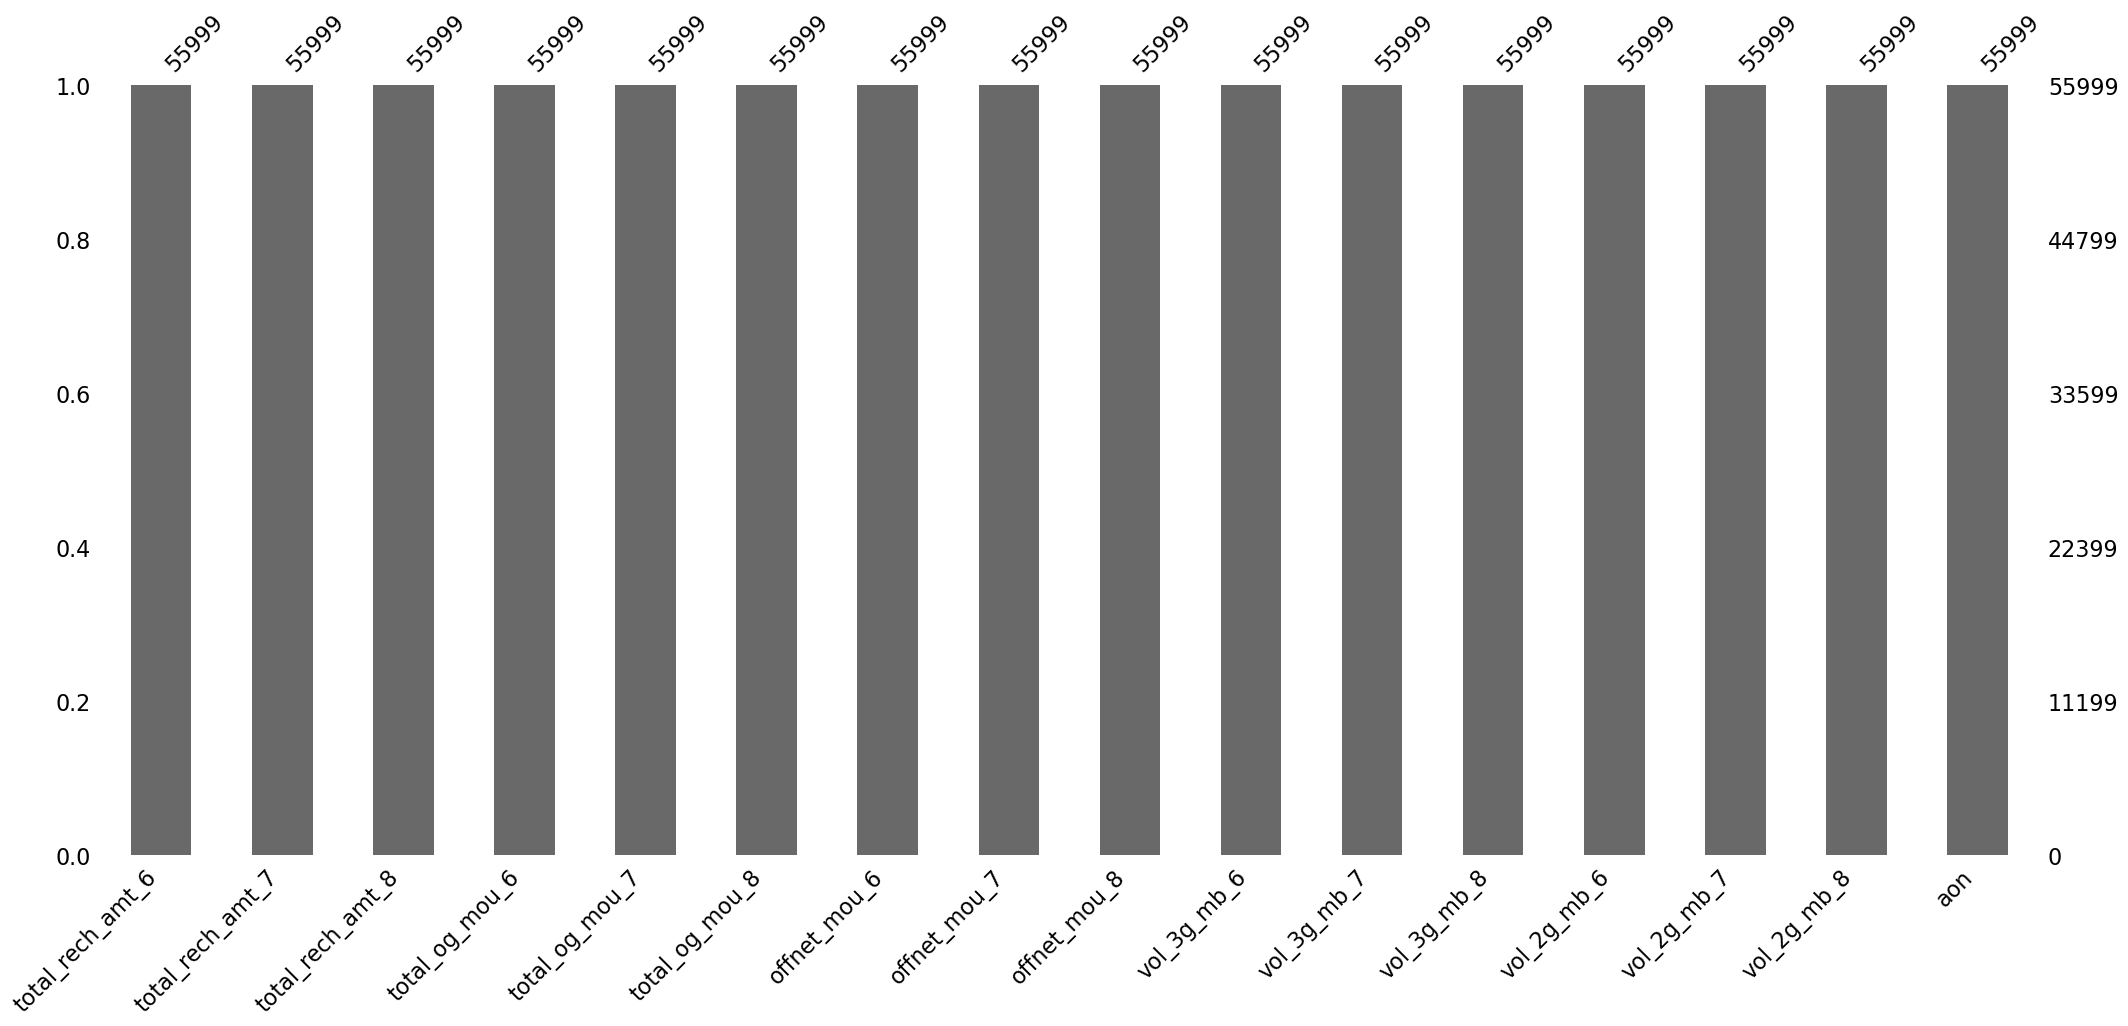

In [20]:
msno.bar(X_train_filtered)

In [21]:
y_train.isnull().sum()

0

In [22]:
X_train.isnull().sum()/len(y_train)

total_rech_amt_6    0.000000
total_rech_amt_7    0.000000
total_rech_amt_8    0.000000
total_og_mou_6      0.000000
total_og_mou_7      0.000000
total_og_mou_8      0.000000
offnet_mou_6        0.039822
offnet_mou_7        0.038911
offnet_mou_8        0.052769
arpu_3g_6           0.749335
arpu_3g_7           0.746513
arpu_3g_8           0.737585
arpu_2g_6           0.749335
arpu_2g_7           0.746513
arpu_2g_8           0.737585
vol_3g_mb_6         0.000000
vol_3g_mb_7         0.000000
vol_3g_mb_8         0.000000
vol_2g_mb_6         0.000000
vol_2g_mb_7         0.000000
vol_2g_mb_8         0.000000
aon                 0.000000
dtype: float64

In [23]:
X_train_filtered.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,aon
count,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000,55999.000000
mean,328.951642,322.771174,325.420900,307.674861,311.258955,305.893422,191.653003,190.460802,187.413694,122.314354,128.850942,135.882480,51.703209,50.711553,50.128216,1222.100091
std,415.636489,422.628441,442.591211,467.085125,478.771623,479.955030,312.012285,320.212373,321.230421,557.610281,553.127227,575.689619,216.295798,210.086154,215.526526,953.401118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000
25%,109.000000,100.000000,90.000000,44.980000,42.830000,38.720000,28.960000,26.680000,23.955000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,467.500000
50%,230.000000,220.000000,225.000000,146.010000,140.980000,138.040000,90.290000,85.560000,83.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000
75%,440.000000,430.000000,438.000000,377.430000,380.475000,372.210000,224.780000,219.485000,218.235000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1821.500000
max,35190.000000,40335.000000,45320.000000,10674.030000,8285.640000,14043.060000,6712.810000,7043.980000,14007.340000,45735.400000,28144.120000,30036.060000,10285.900000,7873.550000,11117.610000,4337.000000


# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

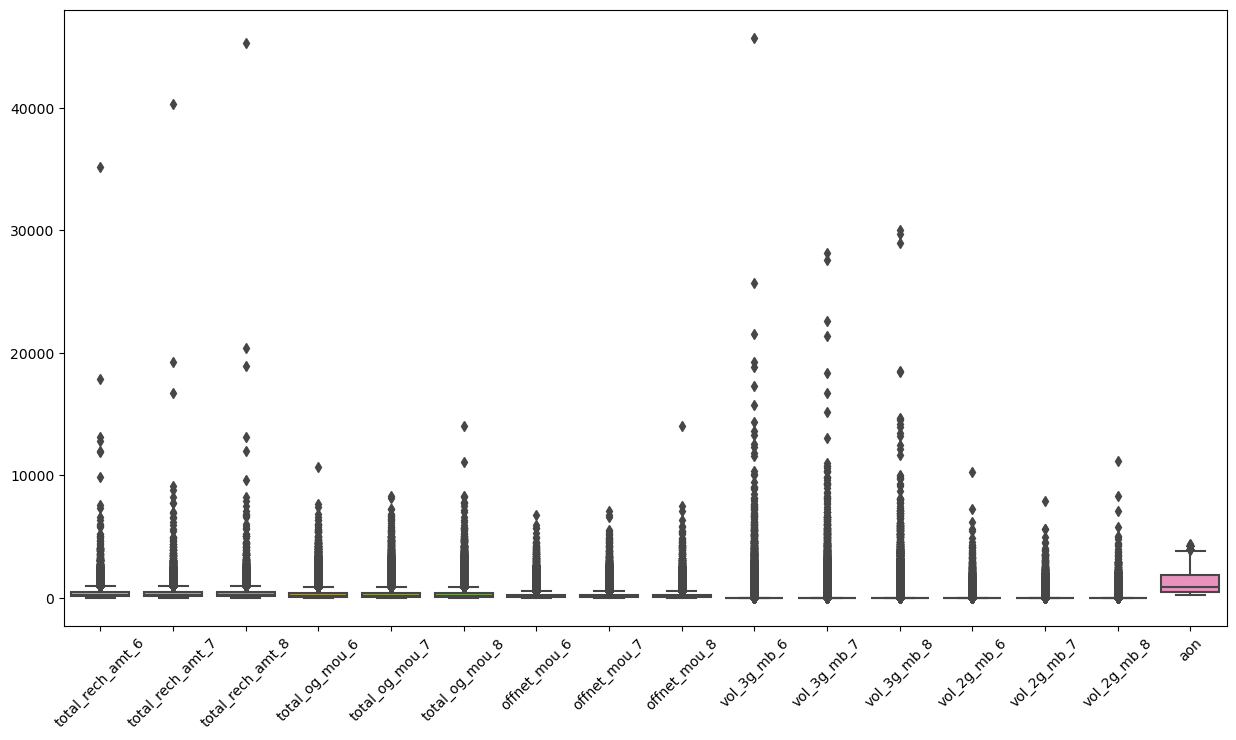

In [24]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [25]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

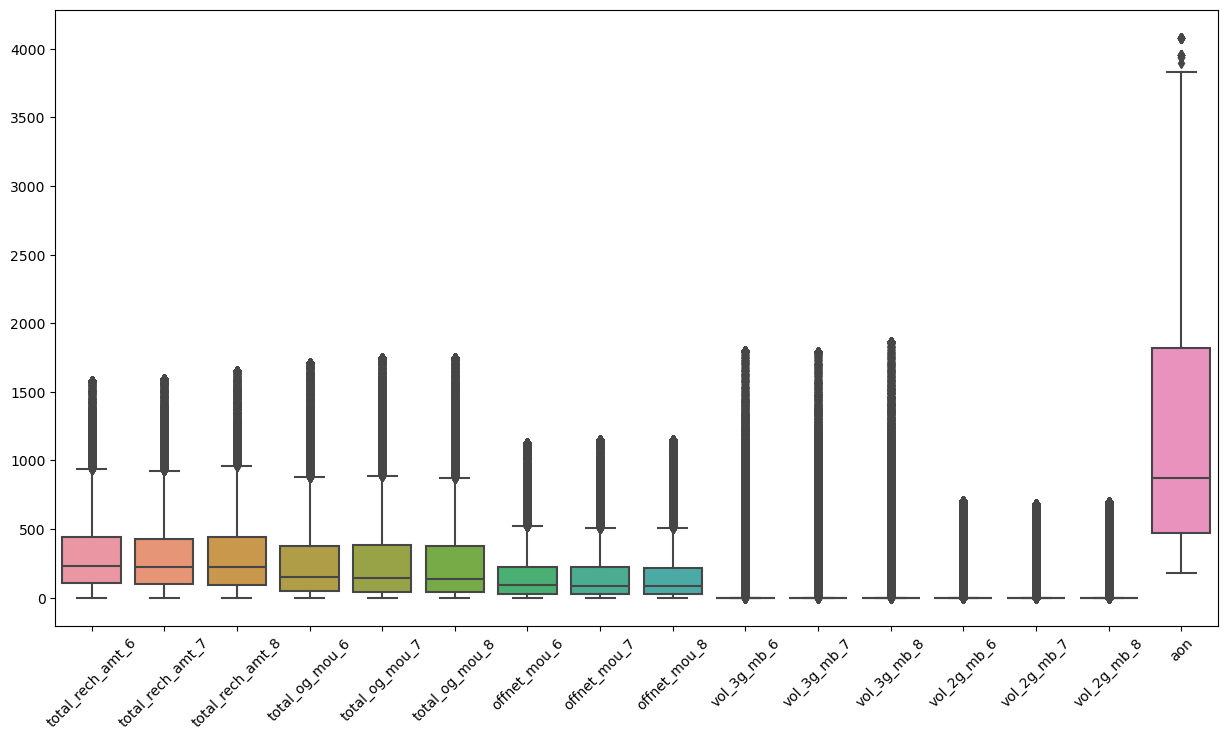

In [26]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

In [27]:
# Handling DATA IMBALANCE

In [28]:
# Check if any NaNs still present
print(np.any(np.isnan(X_train_filtered1)))

False


In [29]:

X_train_filtered1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55999 entries, 57890 to 55168
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_rech_amt_6  55999 non-null  float64
 1   total_rech_amt_7  55999 non-null  float64
 2   total_rech_amt_8  55999 non-null  float64
 3   total_og_mou_6    55999 non-null  float64
 4   total_og_mou_7    55999 non-null  float64
 5   total_og_mou_8    55999 non-null  float64
 6   offnet_mou_6      55999 non-null  float64
 7   offnet_mou_7      55999 non-null  float64
 8   offnet_mou_8      55999 non-null  float64
 9   vol_3g_mb_6       55999 non-null  float64
 10  vol_3g_mb_7       55999 non-null  float64
 11  vol_3g_mb_8       55999 non-null  float64
 12  vol_2g_mb_6       55999 non-null  float64
 13  vol_2g_mb_7       55999 non-null  float64
 14  vol_2g_mb_8       55999 non-null  float64
 15  aon               55999 non-null  float64
dtypes: float64(16)
memory usage: 7.3 MB


In [30]:
y_train.shape

(55999,)

In [31]:
# Imporing SMOTE
from imblearn.over_sampling import SMOTE

In [32]:
# Instantiate SMOTE
sm = SMOTE(random_state=27)

In [33]:
# Fittign SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train_filtered1, y_train)

In [34]:
X_train.shape

(100582, 16)

In [35]:
y_train.shape

(100582,)

In [36]:
y_train.shape

(100582,)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [37]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train)

In [38]:
X_train_filtered2.shape

(100582, 16)

<Axes: >

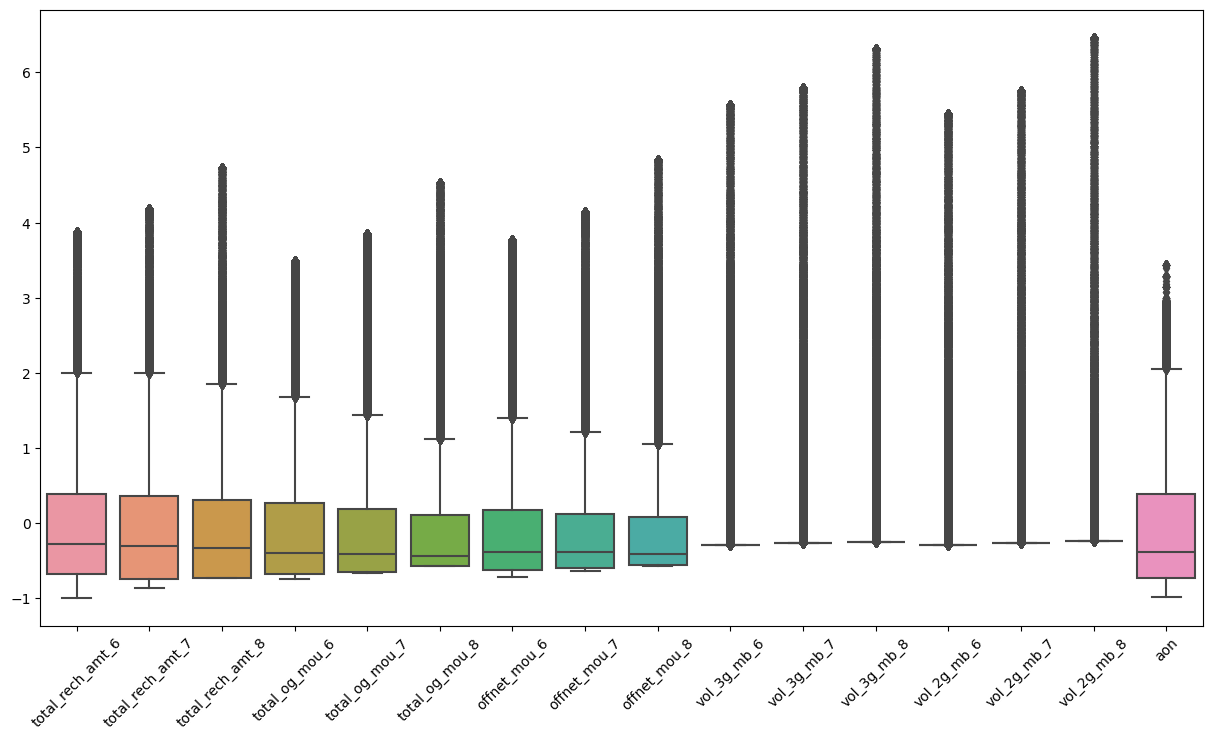

In [39]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

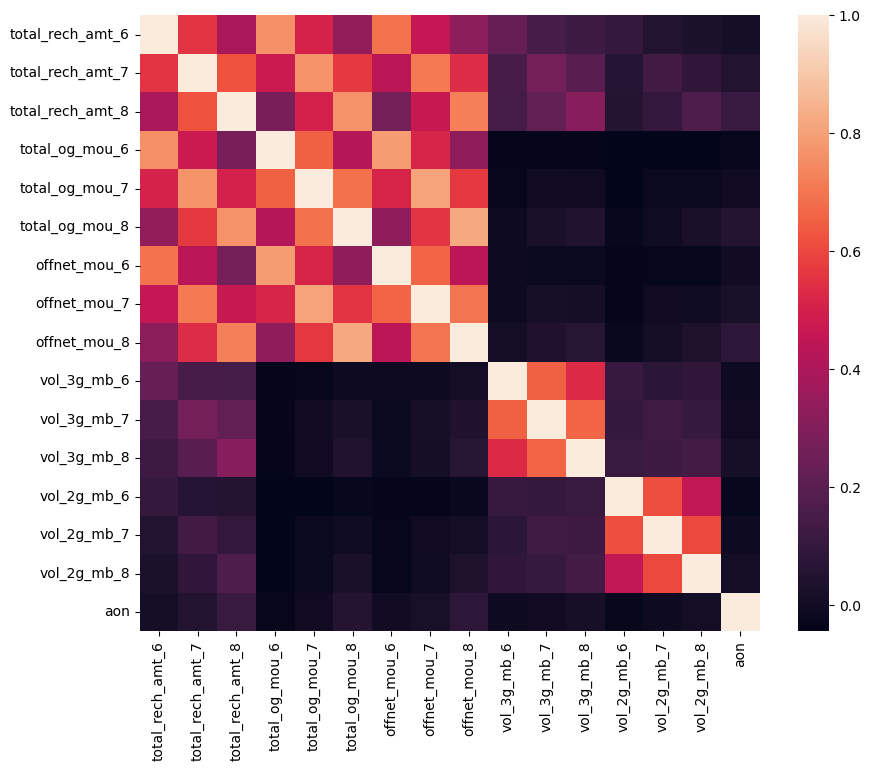

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

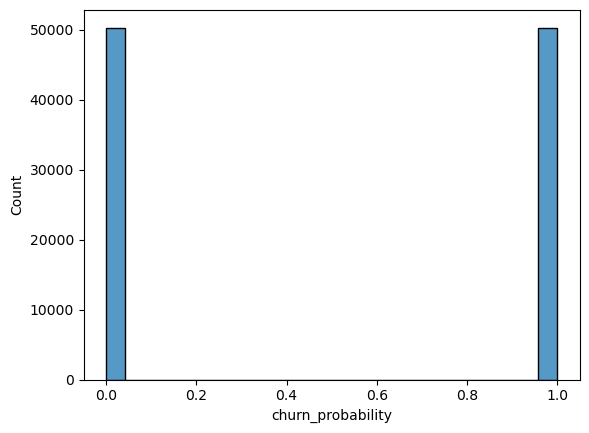

In [41]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [42]:
X_train_filtered2.shape

(100582, 16)

In [43]:
y_train.shape

(100582,)

In [44]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 100582 entries, 0 to 100581
Series name: churn_probability
Non-Null Count   Dtype
--------------   -----
100582 non-null  int64
dtypes: int64(1)
memory usage: 785.9 KB


In [45]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [46]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 16 artists>

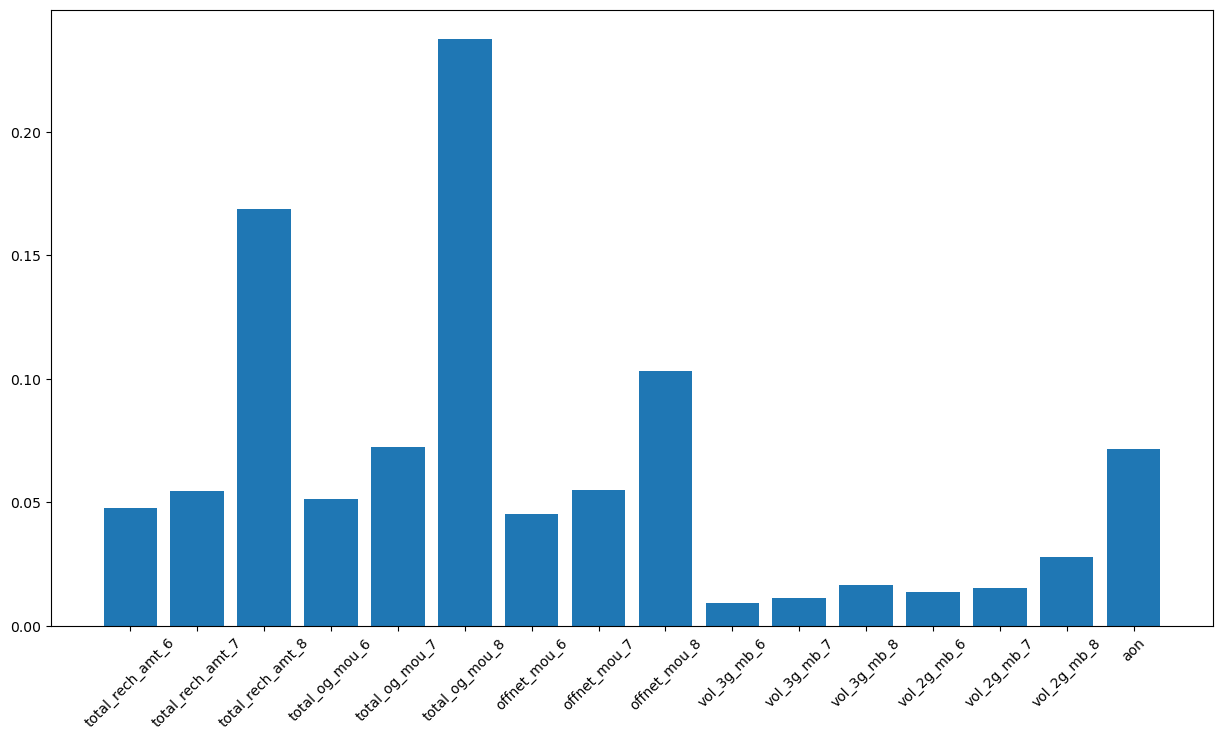

In [47]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [48]:
# Convert the NumPy array to a DataFrame
X_train_filtered2_df = pd.DataFrame(X_train_filtered2)

# Now you can access column
X_train_filtered2_df.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.995678,-0.863227,0.420655,-0.691167,-0.671447,-0.293868,-0.634372,-0.647491,-0.150802,-0.290154,-0.273760,-0.257346,-0.292385,-0.275847,-0.244736,0.610909
1,-0.230363,0.260970,-0.348598,-0.285952,-0.493129,-0.278174,-0.442127,-0.555232,-0.500173,-0.290154,0.766974,-0.257346,-0.292385,-0.161738,-0.244736,0.349403
2,0.812688,1.049491,2.388359,2.613662,2.723834,4.526662,1.793759,1.714679,3.417102,-0.290154,-0.273760,-0.257346,-0.292385,-0.275847,-0.244736,1.222222
3,0.143037,-0.514884,-0.025050,0.591914,0.604990,0.505219,-0.363182,-0.451326,-0.286749,-0.290154,-0.273760,-0.257346,-0.292385,-0.275847,-0.244736,2.170889
4,-0.116183,-0.388214,1.130481,-0.085035,0.436560,1.611205,-0.618567,-0.278372,0.136438,-0.290154,-0.273760,-0.257346,-0.292385,-0.275847,6.464625,1.829007


<Axes: >

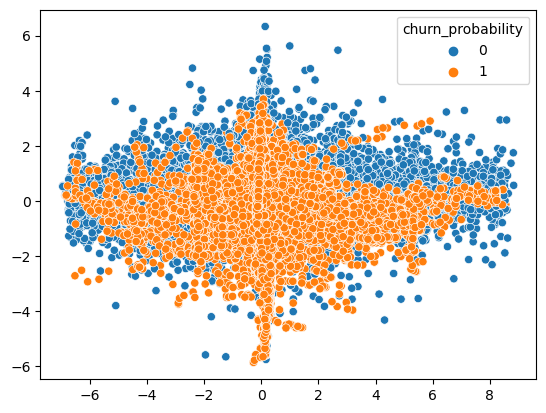

In [49]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,2], y=pca_components[:,5], hue=y_train)

<Axes: >

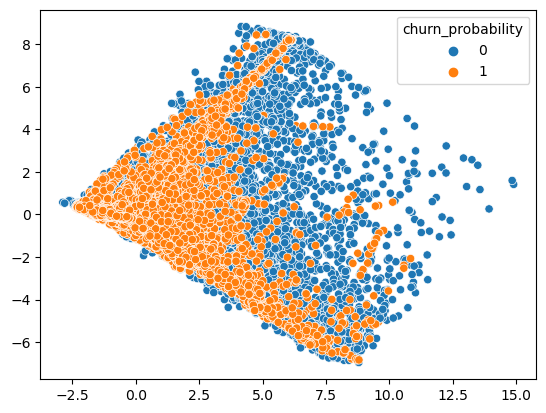

In [50]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [51]:
# Convert the NumPy array to a DataFrame
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(pca_components.shape[1])])

# Now you can access columns
print(pca_df.columns)

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16'],
      dtype='object')


<BarContainer object of 16 artists>

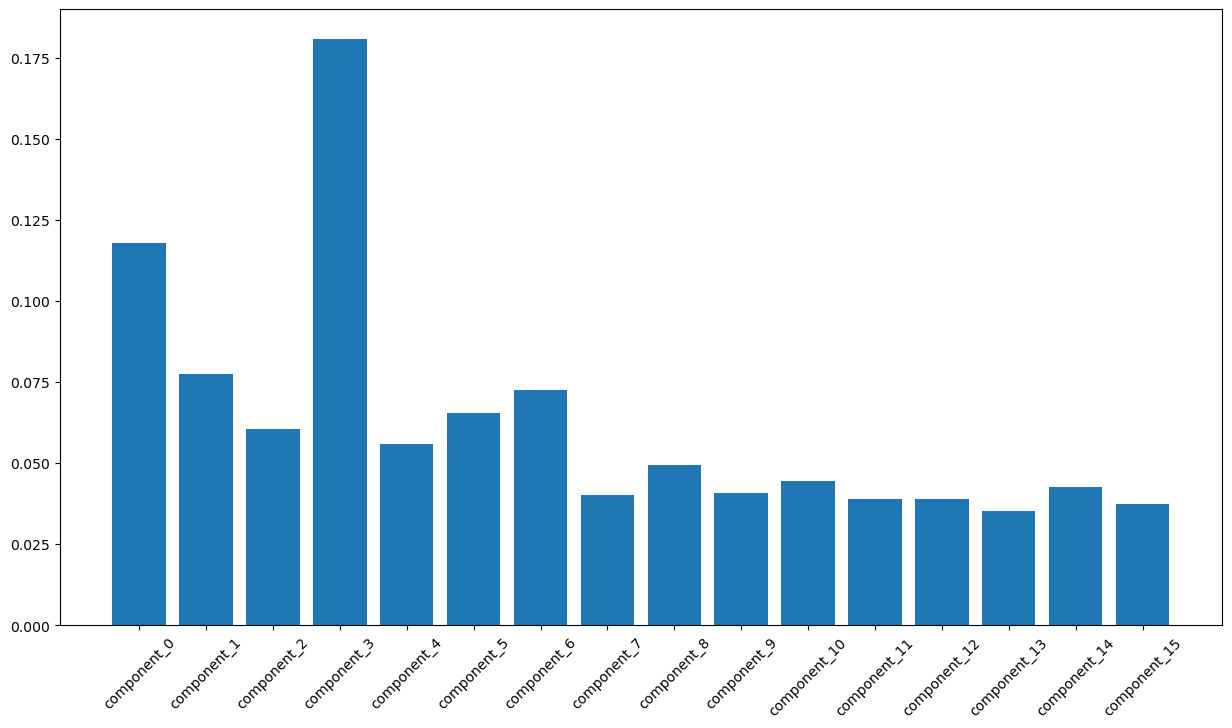

In [52]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [53]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,[2,5]], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [54]:
lr.score(pca_components[:,[2,5]], y_train)

0.5224493448131873

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [55]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.34365326 0.50832938 0.62363429 0.71774038 0.77925987 0.81939155
 0.85413758 0.88587135 0.91535198 0.936917   0.95653156 0.9744598
 0.98394539 0.99137269 0.99720884 1.        ]


Text(0, 0.5, 'Cumulative Variance')

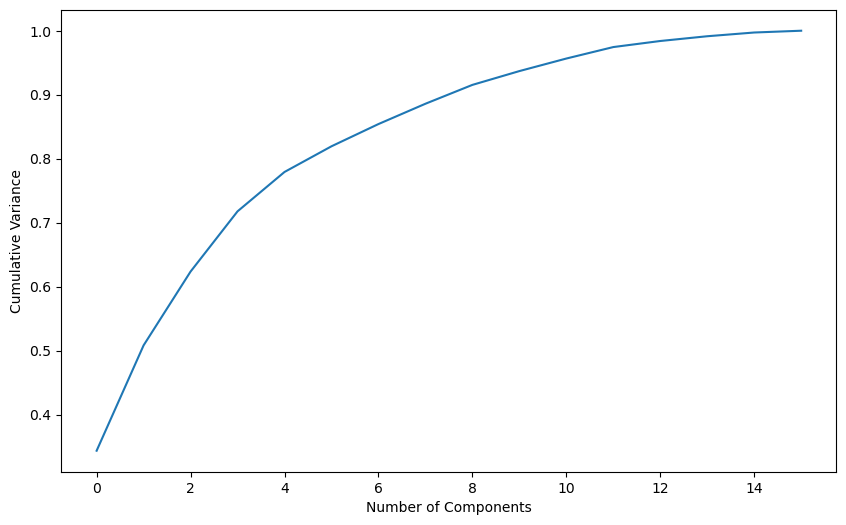

In [56]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [57]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=11)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [58]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [59]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=11)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [60]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.7461971326877572


In [61]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.7017857142857142


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [62]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[35073, 15218],
       [10310, 39981]], dtype=int64)

In [63]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[8702, 3874],
       [ 301, 1123]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [64]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.22473484090454274

In [65]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.788623595505618

## Decision tree with PCA

In [66]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

##### Hyperparameter tuning

In [67]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
#grid_search.fit(X_train[new_vars],y_train)


In [69]:
# Printing the optimal sensitivity score and hyperparameters
#print("Best sensitivity:-", grid_search.best_score_)
#print(grid_search.best_estimator_)

##### Model with optimal hyperparameters

In [70]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',grid_search)])

In [71]:
pipe.fit(X_train[new_vars], y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=11)),
                ('model',
                 GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                              param_grid={'max_depth': range(5, 15, 5),
                                          'min_samples_leaf': range(50, 150, 50),
                                          'min_samples_split': range(50, 150, 50)},
                              scoring='recall', verbose=1))])

In [72]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8164880396094729


In [73]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.7120786516853933


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [74]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[43229,  7062],
       [ 9229, 41062]], dtype=int64)

In [75]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[10627,  1949],
       [  410,  1014]], dtype=int64)

In [76]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.342220722240972

In [77]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.7120786516853933

In [78]:
# Model with optimal hyperparameters
dt_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_pca_model.fit(X_train[new_vars], y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

##### Prediction on the train set

In [79]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=11)


In [80]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',dt_pca_model)])

In [81]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=11)),
                ('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=50,
                                        min_samples_split=50,
                                        random_state=100))])

In [82]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.8380326499771331


In [83]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.8315


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [84]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[43229,  7062],
       [ 9229, 41062]], dtype=int64)

In [85]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[10627,  1949],
       [  410,  1014]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [86]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.342220722240972

In [87]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.7120786516853933

## Random forest with PCA

In [88]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

##### Hyperparameter tuning

In [89]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,100,100], 
    'max_features': [10, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
#grid_search.fit(X_train[new_vars], y_train)


In [90]:
# printing the optimal accuracy score and hyperparameters
#print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

##### 

Model with optimal hyperparameters

In [91]:
# model with the best hyperparameters

rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=50,
                             max_features=10,
                             n_estimators=100)

In [92]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=11)


In [93]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',rfc_model)])

In [94]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=11)),
                ('model',
                 RandomForestClassifier(max_depth=5, max_features=10,
                                        min_samples_leaf=50,
                                        min_samples_split=50))])

In [95]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.7982143922371796


In [96]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.7957142857142857


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [97]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[41053,  9238],
       [11058, 39233]], dtype=int64)

In [98]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[10090,  2486],
       [  374,  1050]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [99]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

0.29694570135746606

In [100]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

0.7373595505617978

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [101]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [102]:
unseen.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [103]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

(30000, 16)

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [106]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,1
4,70003,0


Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [107]:
output.to_csv('submission_pca_lr_20Oct.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

### Final conclusion with PCA
After trying several models we can see that for acheiving the best sensitivity, which was our ultimate goal, the classic Logistic regression. For  the model the sensitivity was approx 79%. Also we have good accuracy of apporx 85%.

# Without PCA

## Logistic regression with No PCA

In [108]:
#getting original dataset

In [109]:
df_train = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

In [110]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df_train.isnull().sum()/len(df_train.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
arpu_3g_6,74.9
count_rech_2g_6,74.9
night_pck_user_6,74.9
arpu_2g_6,74.9
date_of_last_rech_data_6,74.9
...,...
last_day_rch_amt_8,0.0
vol_2g_mb_6,0.0
vol_2g_mb_7,0.0
vol_2g_mb_8,0.0


In [111]:
# List the columns having more than 30% missing values
col_list_missing_40 = list(df_missing_columns.index[df_missing_columns['null'] > 40])
col_list_missing_40

['arpu_3g_6',
 'count_rech_2g_6',
 'night_pck_user_6',
 'arpu_2g_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'av_rech_amt_data_6',
 'max_rech_data_6',
 'count_rech_3g_6',
 'fb_user_6',
 'night_pck_user_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'fb_user_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'arpu_3g_7',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'count_rech_2g_8',
 'av_rech_amt_data_8',
 'night_pck_user_8',
 'max_rech_data_8',
 'total_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'count_rech_3g_8']

In [112]:
# Delete the columns having more than 30% missing values
df_train = df_train.drop(col_list_missing_40, axis=1)

In [113]:
df_train.shape

(69999, 142)

##### Deleting the date columns as the date columns are not required in our analysis

In [114]:
# List the date columns
date_cols = [i for i in df_train.columns.to_list() if 'date' in i]
print(date_cols) 


['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [115]:
# Dropping date columns
df_train = df_train.drop(date_cols, axis=1)

In [116]:
unique_counts = df_train.nunique()
print(unique_counts)

id                   69999
circle_id                1
loc_og_t2o_mou           1
std_og_t2o_mou           1
loc_ic_t2o_mou           1
                     ...  
aon                   3455
aug_vbc_3g           10609
jul_vbc_3g           10257
jun_vbc_3g            9617
churn_probability        2
Length: 136, dtype: int64


In [117]:
single_val_col = df_train.columns[df_train.apply(pd.Series.nunique) < 2]
df_single_val = df_train[single_val_col]
df_single_val.nunique()

circle_id           1
loc_og_t2o_mou      1
std_og_t2o_mou      1
loc_ic_t2o_mou      1
std_og_t2c_mou_6    1
std_og_t2c_mou_7    1
std_og_t2c_mou_8    1
std_ic_t2o_mou_6    1
std_ic_t2o_mou_7    1
std_ic_t2o_mou_8    1
dtype: int64

In [118]:
df_single_val.describe()

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
count,69999.0,69297.0,69297.0,69297.0,67231.0,67312.0,66296.0,67231.0,67312.0,66296.0
mean,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
multival_columns = df_train.columns[df_train.apply(pd.Series.nunique) > 1]
df_multi_val = df_train[multival_columns]
df_multi_val.nunique()

id                   69999
arpu_6               61615
arpu_7               61425
arpu_8               60194
onnet_mou_6          20057
                     ...  
aon                   3455
aug_vbc_3g           10609
jul_vbc_3g           10257
jun_vbc_3g            9617
churn_probability        2
Length: 126, dtype: int64

In [120]:
df_train.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.077730,0.081958,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.383189,0.381821,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,16.000000,16.000000,29.000000,33.000000,41.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


Dropping all columns with single value asthey has only one unique value leading to nil impact prediction.

In [121]:
# Drop circle_id column
df_train = df_train.drop(df_single_val, axis=1)

In [122]:
df_train.shape

(69999, 126)

In [123]:
 ### Finding Customers Phase
# Good Phase (jun-6,jul-7)
# Action Phase (Aug-8)
# Churn Phase (Sep -9)


### Filter high-value customers

Creating column `good and action` by summing up total arpu amount of month 6,7 separate & 8 seaparate. 

In [124]:
df_train['av_arpu_good'] = (df_train['arpu_6']+ df_train['arpu_7'])/2

df_train['av_arpu_action']= (df_train['arpu_8'] - df_train['av_arpu_good'])
df_train.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,av_arpu_good,av_arpu_action
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0,0,1958,0.0,0.0,0.0,0,59.1430,-51.6160
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0,0,0,710,0.0,0.0,0.0,0,61.3935,-18.4405
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0,0,882,0.0,0.0,0.0,0,81.9910,-81.9910
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0,0,982,0.0,0.0,0.0,0,180.8110,-69.7160
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,1,0,647,0.0,0.0,0.0,0,184.4495,-82.8845


Filter the customers, who have recharged more than or equal to X.

In [125]:
df_train = df_train[df_train['av_arpu_action'] < 0]
df_train.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,av_arpu_good,av_arpu_action
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0,0,1958,0.0,0.0,0.0,0,59.1430,-51.6160
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0,0,0,710,0.0,0.0,0.0,0,61.3935,-18.4405
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0,0,882,0.0,0.0,0.0,0,81.9910,-81.9910
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0,0,982,0.0,0.0,0.0,0,180.8110,-69.7160
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,1,0,647,0.0,0.0,0.0,0,184.4495,-82.8845


In [126]:
df_train.shape

(36740, 128)

In [127]:
def calculate_average_and_difference(df, column_prefixes):

    for column_prefix in column_prefixes:
        # Create average column
        col_avg = f"av_{column_prefix}_good"
        df[col_avg] = (df[f"{column_prefix}_6"] + df[f"{column_prefix}_7"]) / 2

        # Create difference column
        col_diff = f"av_{column_prefix}_action"
        df[col_diff] = df[f"{column_prefix}_8"] - df[col_avg]

    return df

prefixes = ['onnet_mou',
'offnet_mou',
'roam_ic_mou',
'roam_og_mou',
'loc_og_t2t_mou',
'loc_og_t2t_mou',
'loc_og_t2m_mou',
'loc_og_t2f_mou',
'loc_og_t2c_mou',
'loc_og_mou',
'std_og_t2t_mou',
'std_og_t2m_mou',
'std_og_t2f_mou',
'std_og_mou',
'isd_og_mou',
'spl_og_mou',
'og_others',
'total_og_mou',
'loc_ic_t2t_mou',
'loc_ic_t2m_mou',
'loc_ic_t2f_mou',
'loc_ic_mou',
'std_ic_t2t_mou',
'std_ic_t2m_mou',
'std_ic_t2f_mou',
'std_ic_mou',
'total_ic_mou',
'spl_ic_mou',
'isd_ic_mou',
'ic_others',
'total_rech_num',
'total_rech_amt',
'max_rech_amt',
'last_day_rch_amt',
'vol_2g_mb',
'vol_3g_mb',
'monthly_2g',
'sachet_2g',
'monthly_3g',
'sachet_3g'
           ]

df_train = calculate_average_and_difference(df_train, prefixes)

df_train.head()


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,av_vol_3g_mb_good,av_vol_3g_mb_action,av_monthly_2g_good,av_monthly_2g_action,av_sachet_2g_good,av_sachet_2g_action,av_monthly_3g_good,av_monthly_3g_action,av_sachet_3g_good,av_sachet_3g_action
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,1.98,-1.98,0.0,0.0,0.0,0.0,0.5,-0.5,0.0,0.0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0.00,0.00,0.0,0.0,6.5,-0.5,0.0,0.0,0.5,-0.5


In [128]:
df_train.head()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,av_vol_3g_mb_good,av_vol_3g_mb_action,av_monthly_2g_good,av_monthly_2g_action,av_sachet_2g_good,av_sachet_2g_action,av_monthly_3g_good,av_monthly_3g_action,av_sachet_3g_good,av_sachet_3g_action
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,1.98,-1.98,0.0,0.0,0.0,0.0,0.5,-0.5,0.0,0.0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0.00,0.00,0.0,0.0,6.5,-0.5,0.0,0.0,0.5,-0.5


In [129]:
def add_and_drop_columns(df, column_list, postfix_list):
  
  # Add postfixes to specified column names
  new_columns = []
  for column in column_list:
    for postfix in postfix_list:
      new_column = f"{column}_{postfix}"
      new_columns.append(new_column)

  # Check if new columns exist and drop them
  existing_columns = set(new_columns).intersection(set(df.columns))
  df.drop(columns=existing_columns, inplace=True)

  return df


postfix_list = [6, 7, 8]

df_train = add_and_drop_columns(df_train, prefixes, postfix_list)

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36740 entries, 0 to 69997
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36740 non-null  int64  
 1   arpu_6                      36740 non-null  float64
 2   arpu_7                      36740 non-null  float64
 3   arpu_8                      36740 non-null  float64
 4   aon                         36740 non-null  int64  
 5   aug_vbc_3g                  36740 non-null  float64
 6   jul_vbc_3g                  36740 non-null  float64
 7   jun_vbc_3g                  36740 non-null  float64
 8   churn_probability           36740 non-null  int64  
 9   av_arpu_good                36740 non-null  float64
 10  av_arpu_action              36740 non-null  float64
 11  av_onnet_mou_good           34749 non-null  float64
 12  av_onnet_mou_action         32841 non-null  float64
 13  av_offnet_mou_good          34749 no

#### Handling missing values in rows

<Axes: >

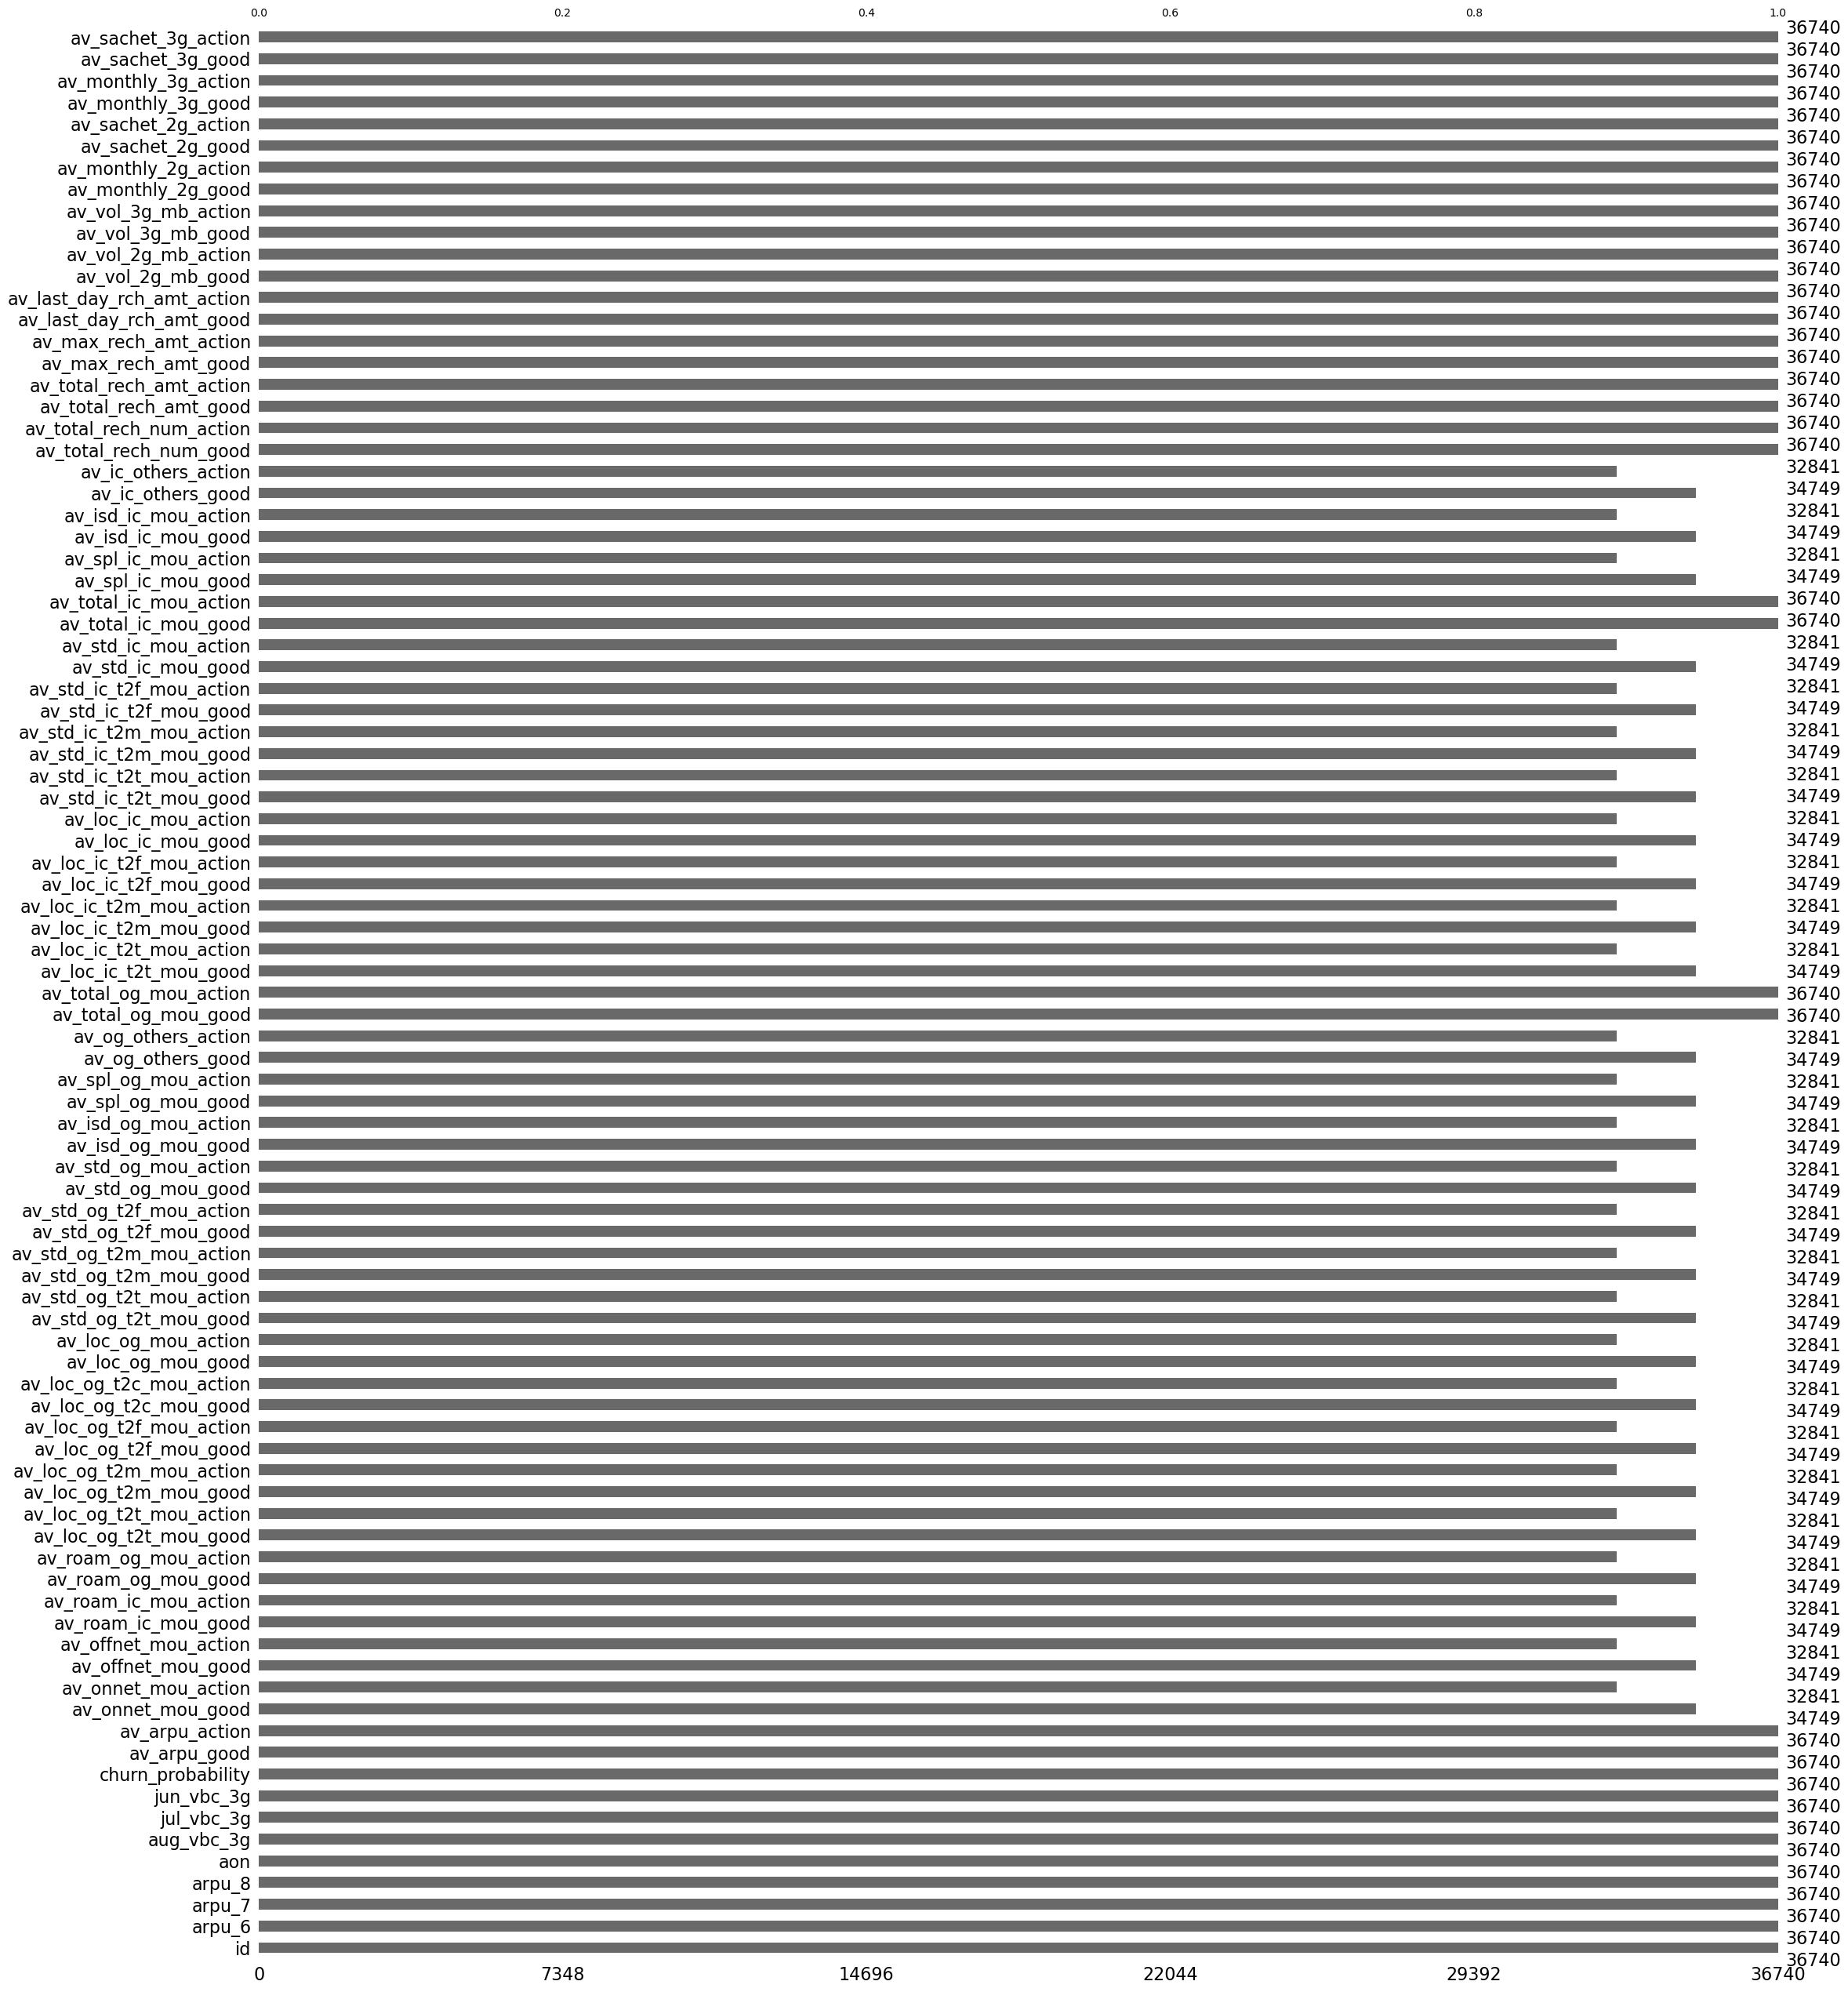

In [130]:
msno.bar(df_train)

<Axes: >

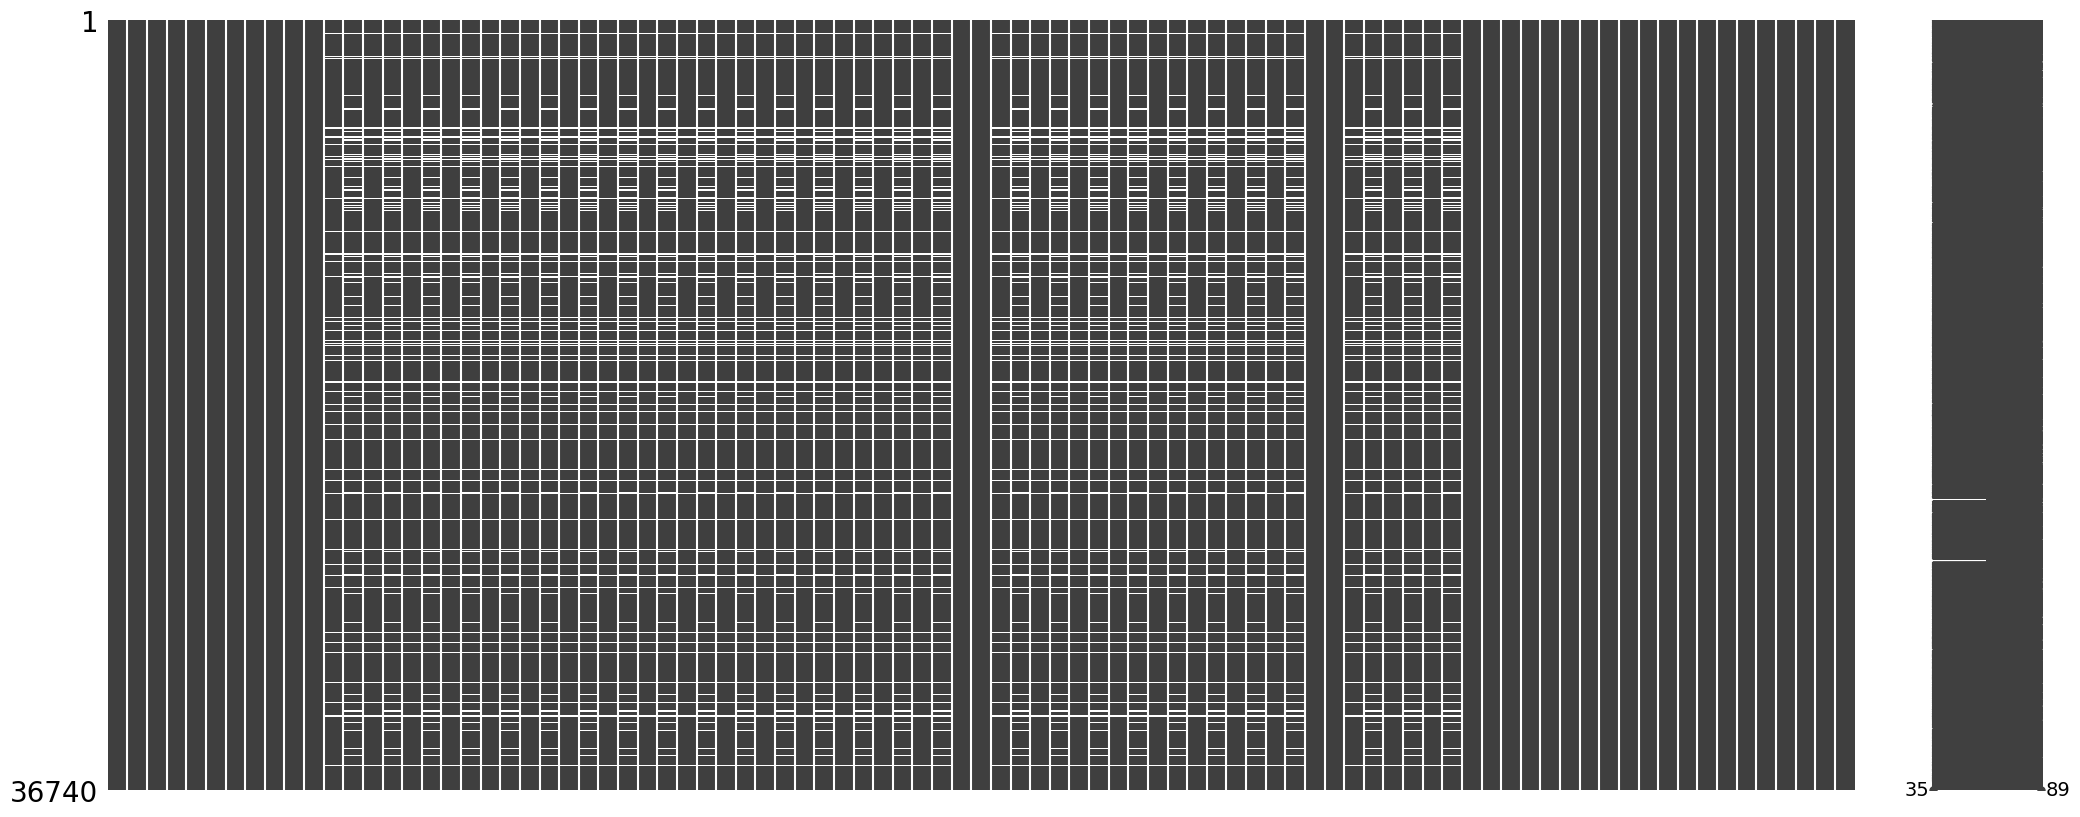

In [131]:
msno.matrix(df_train)

Lets also calculate the % missing data for each column:

In [132]:
missing_data_percent = 100*df_train.isnull().sum()/len(y_train)
missing_data_percent

id                      0.0
arpu_6                  0.0
arpu_7                  0.0
arpu_8                  0.0
aon                     0.0
                       ... 
av_sachet_2g_action     0.0
av_monthly_3g_good      0.0
av_monthly_3g_action    0.0
av_sachet_3g_good       0.0
av_sachet_3g_action     0.0
Length: 89, dtype: float64

In [133]:
missing_data_percent = df_train.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['av_onnet_mou_good', 'av_onnet_mou_action', 'av_offnet_mou_good',
       'av_offnet_mou_action', 'av_roam_ic_mou_good', 'av_roam_ic_mou_action',
       'av_roam_og_mou_good', 'av_roam_og_mou_action',
       'av_loc_og_t2t_mou_good', 'av_loc_og_t2t_mou_action',
       'av_loc_og_t2m_mou_good', 'av_loc_og_t2m_mou_action',
       'av_loc_og_t2f_mou_good', 'av_loc_og_t2f_mou_action',
       'av_loc_og_t2c_mou_good', 'av_loc_og_t2c_mou_action',
       'av_loc_og_mou_good', 'av_loc_og_mou_action', 'av_std_og_t2t_mou_good',
       'av_std_og_t2t_mou_action', 'av_std_og_t2m_mou_good',
       'av_std_og_t2m_mou_action', 'av_std_og_t2f_mou_good',
       'av_std_og_t2f_mou_action', 'av_std_og_mou_good',
       'av_std_og_mou_action', 'av_isd_og_mou_good', 'av_isd_og_mou_action',
       'av_spl_og_mou_good', 'av_spl_og_mou_action', 'av_og_others_good',
       'av_og_others_action', 'av_loc_ic_t2t_mou_good',
       'av_loc_ic_t2t_mou_action', 'av_loc_ic_t2m_mou_good',
       'av_loc_ic_t2m_m

In [134]:
imp = SimpleImputer(strategy='constant', fill_value=0)
df_train[impute_cols] = imp.fit_transform(df_train[impute_cols])

In [135]:
df_train = df_train.fillna(0)

<Axes: >

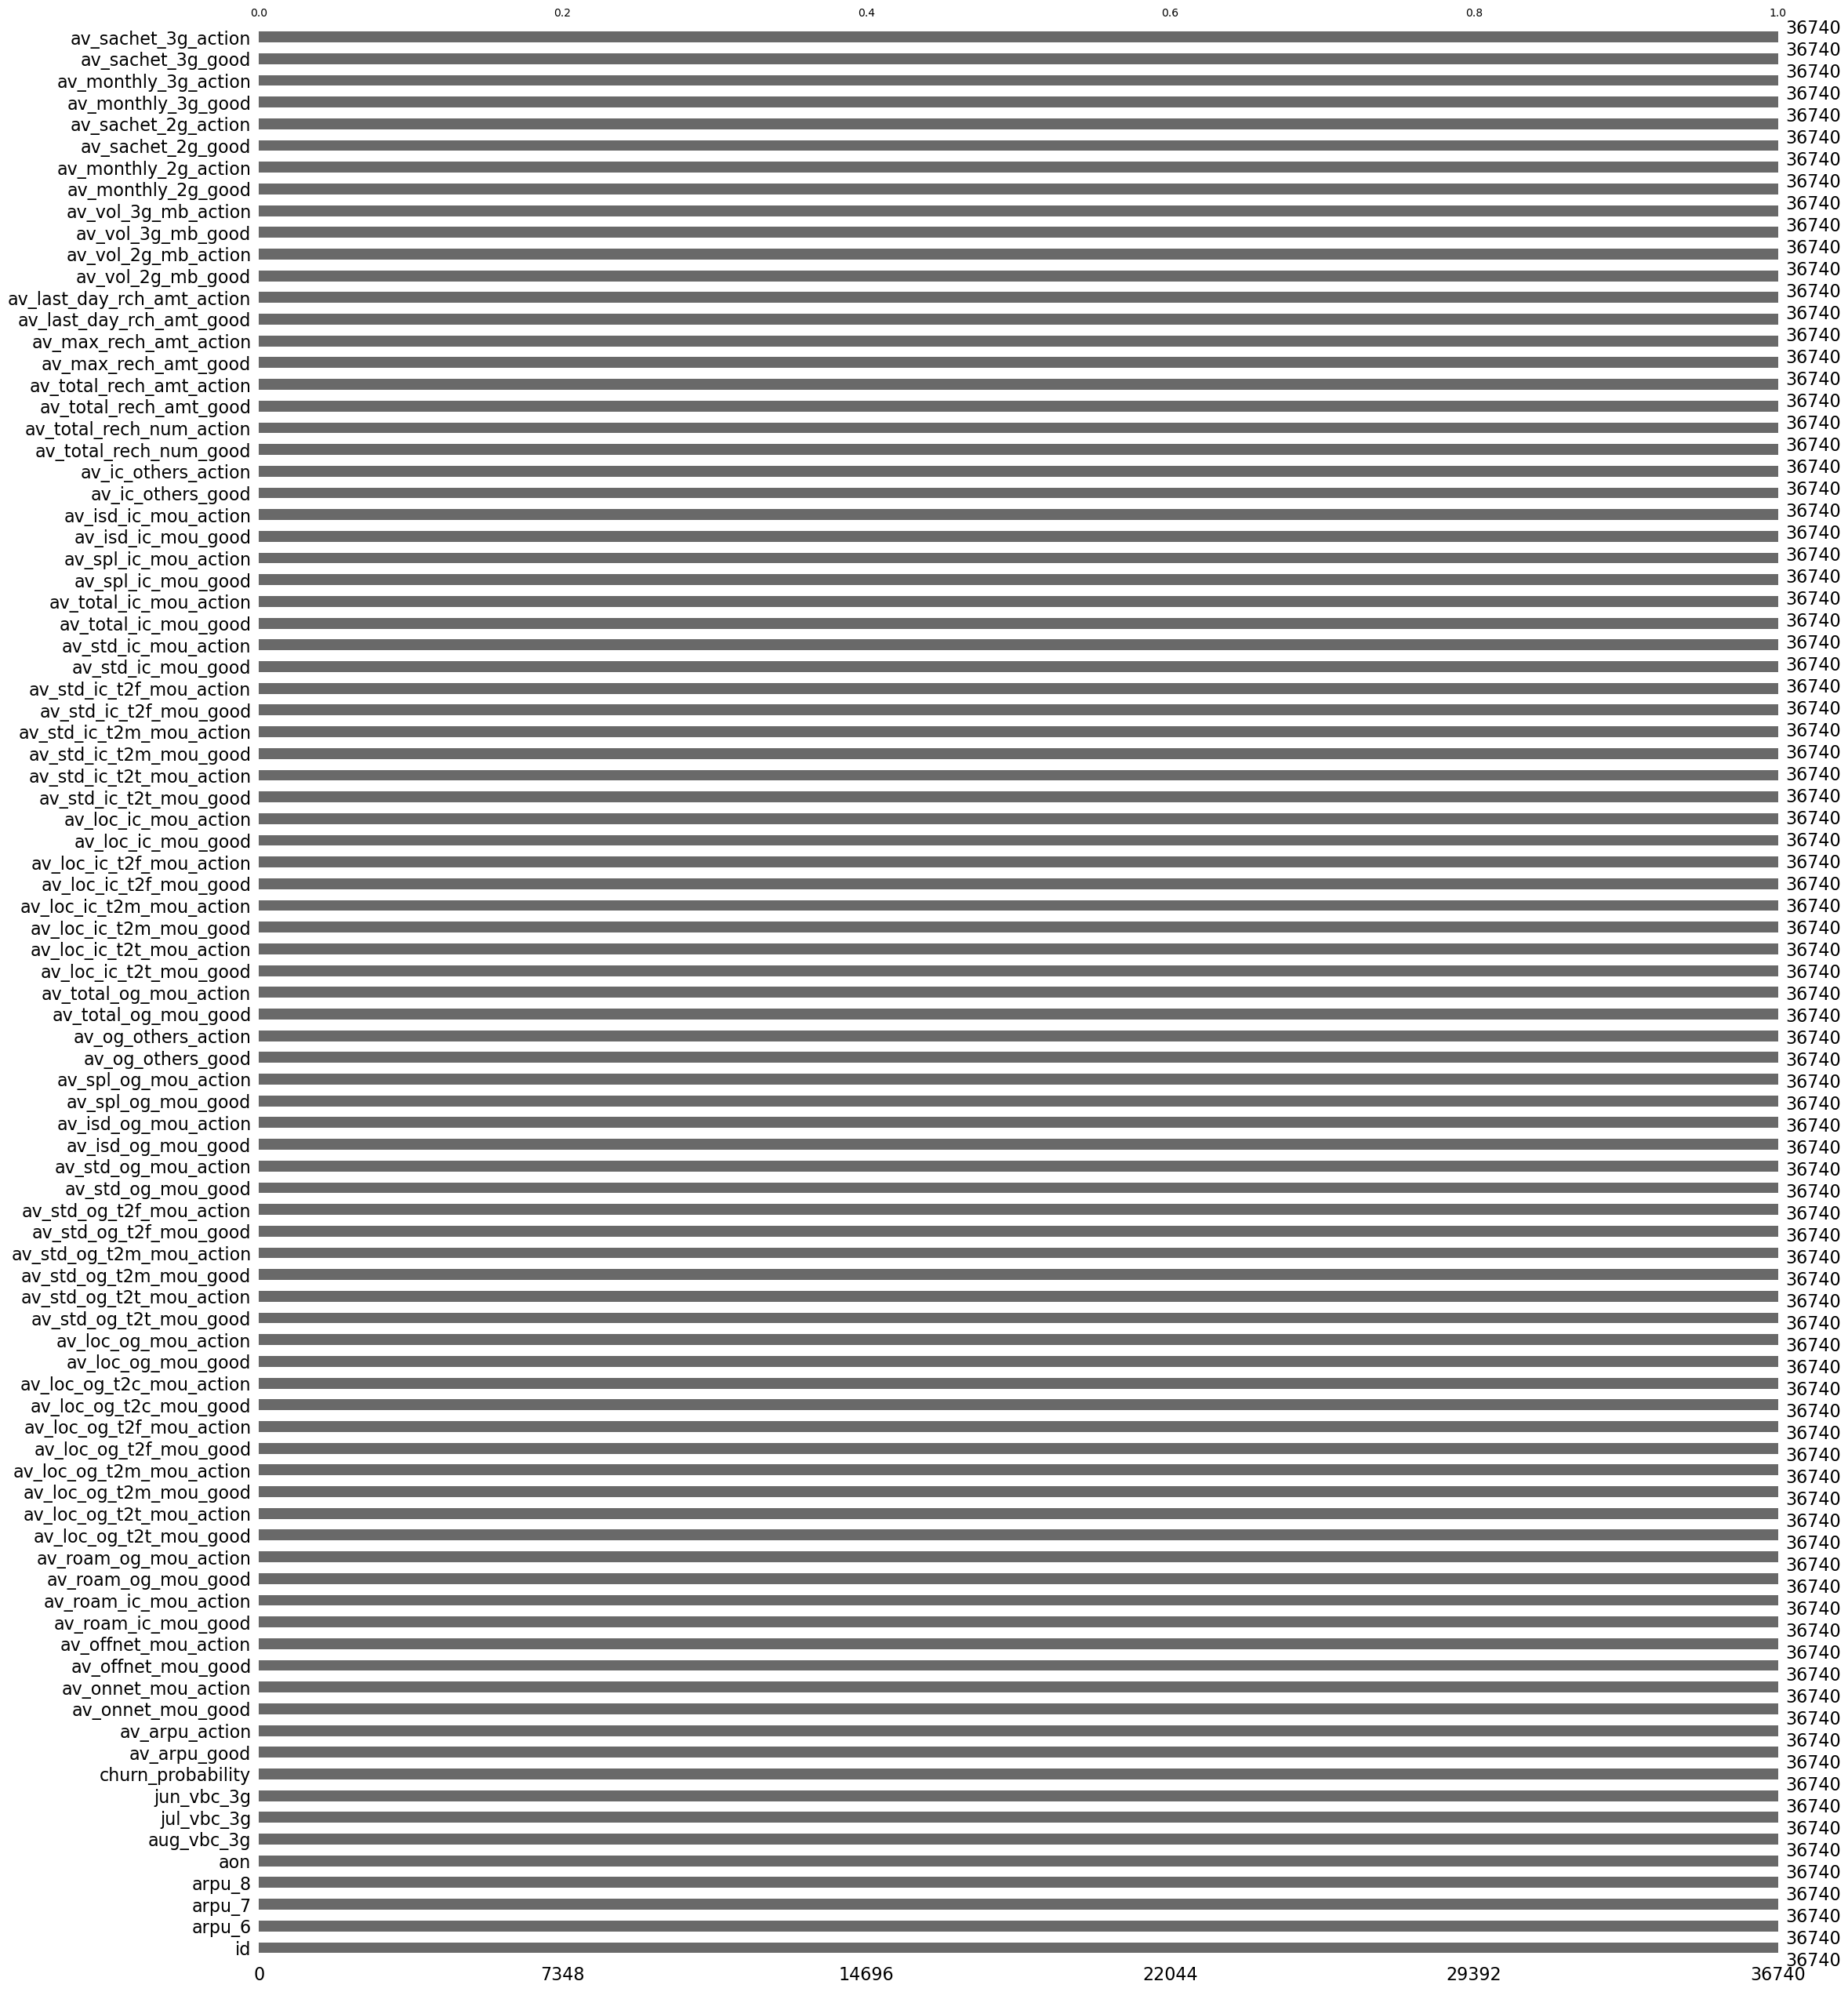

In [136]:
msno.bar(df_train)

In [137]:
# Count the rows having more than 50% missing values
df_missing_rows_50 = df_train[(df_train.isnull().sum(axis=1)) > (len(df_train.columns)//2)]
df_missing_rows_50.shape

(0, 89)

In [138]:
# Deleting the rows having more than 50% missing values
df_train = df_train.drop(df_missing_rows_50.index)
df_train.shape

(36740, 89)

In [139]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36740 entries, 0 to 69997
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36740 non-null  int64  
 1   arpu_6                      36740 non-null  float64
 2   arpu_7                      36740 non-null  float64
 3   arpu_8                      36740 non-null  float64
 4   aon                         36740 non-null  int64  
 5   aug_vbc_3g                  36740 non-null  float64
 6   jul_vbc_3g                  36740 non-null  float64
 7   jun_vbc_3g                  36740 non-null  float64
 8   churn_probability           36740 non-null  int64  
 9   av_arpu_good                36740 non-null  float64
 10  av_arpu_action              36740 non-null  float64
 11  av_onnet_mou_good           36740 non-null  float64
 12  av_onnet_mou_action         36740 non-null  float64
 13  av_offnet_mou_good          36740 no

In [140]:
# Checking the missing values in columns again
df_missing_columns = (round(((df_train.isnull().sum()/len(df_train.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns.describe()

,null
count,89.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [141]:
# Again Cheking percent of missing values in columns
df_missing_columns = (round(((df_train.isnull().sum()/len(df_train.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
id,0.0
av_loc_ic_t2t_mou_good,0.0
av_isd_ic_mou_good,0.0
av_spl_ic_mou_action,0.0
av_spl_ic_mou_good,0.0
...,...
av_loc_og_mou_action,0.0
av_loc_og_mou_good,0.0
av_loc_og_t2c_mou_action,0.0
av_loc_og_t2c_mou_good,0.0


In [142]:
df_train.isnull().sum()

id                      0
arpu_6                  0
arpu_7                  0
arpu_8                  0
aon                     0
                       ..
av_sachet_2g_action     0
av_monthly_3g_good      0
av_monthly_3g_action    0
av_sachet_3g_good       0
av_sachet_3g_action     0
Length: 89, dtype: int64

In [143]:
df_train.shape

(36740, 89)

We can see there are no more missing values in any columns.

In [144]:
# Checking percentage of rows we have lost while handling the missing values
round((1- (len(df_train.index)/36740)),2)

0.0

In [145]:
"""
def drop_columns_with_postfix(df, postfix):
 

  columns_to_drop = [col for col in df.columns if col.endswith(postfix)]
  df.drop(columns=columns_to_drop, inplace=True)
  return df


postfix = "good"

df_train = drop_columns_with_postfix(df_train, postfix)

df_train.shape

SyntaxError: incomplete input (4254947155.py, line 1)

In [ ]:
df_train.head()

#### Deleting all the attributes corresponding to the churn phase

#### Checking churn percentage

In [ ]:
round(100*(df_train['churn_probability'].mean()),2)

There is very little percentage of churn rate. We will take care of the class imbalance later.

## Outliers treatment

In the filtered dataset except mobile_number and churn columns all the columns are numeric types. Hence, converting mobile_number and churn datatype to object.

In [146]:
numeric_cols = df_train.select_dtypes(include='number').columns
numeric_cols = numeric_cols.drop('id')

In [147]:
# Removing outliers below 10th and above 90th percentile
for col in numeric_cols: 
    q1 = df_train[col].quantile(0.10)
    q3 = df_train[col].quantile(0.90)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    # Assigning the filtered dataset into data
    data = df_train

data.shape

(36740, 89)

In [148]:
###  4.1 Handling outliers
### The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [149]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [150]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36740 entries, 0 to 69997
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          36740 non-null  int64  
 1   arpu_6                      36740 non-null  float64
 2   arpu_7                      36740 non-null  float64
 3   arpu_8                      36740 non-null  float64
 4   aon                         36740 non-null  int64  
 5   aug_vbc_3g                  36740 non-null  float64
 6   jul_vbc_3g                  36740 non-null  float64
 7   jun_vbc_3g                  36740 non-null  float64
 8   churn_probability           36740 non-null  int64  
 9   av_arpu_good                36740 non-null  float64
 10  av_arpu_action              36740 non-null  float64
 11  av_onnet_mou_good           36740 non-null  float64
 12  av_onnet_mou_action         36740 non-null  float64
 13  av_offnet_mou_good          36740 no

<Axes: >

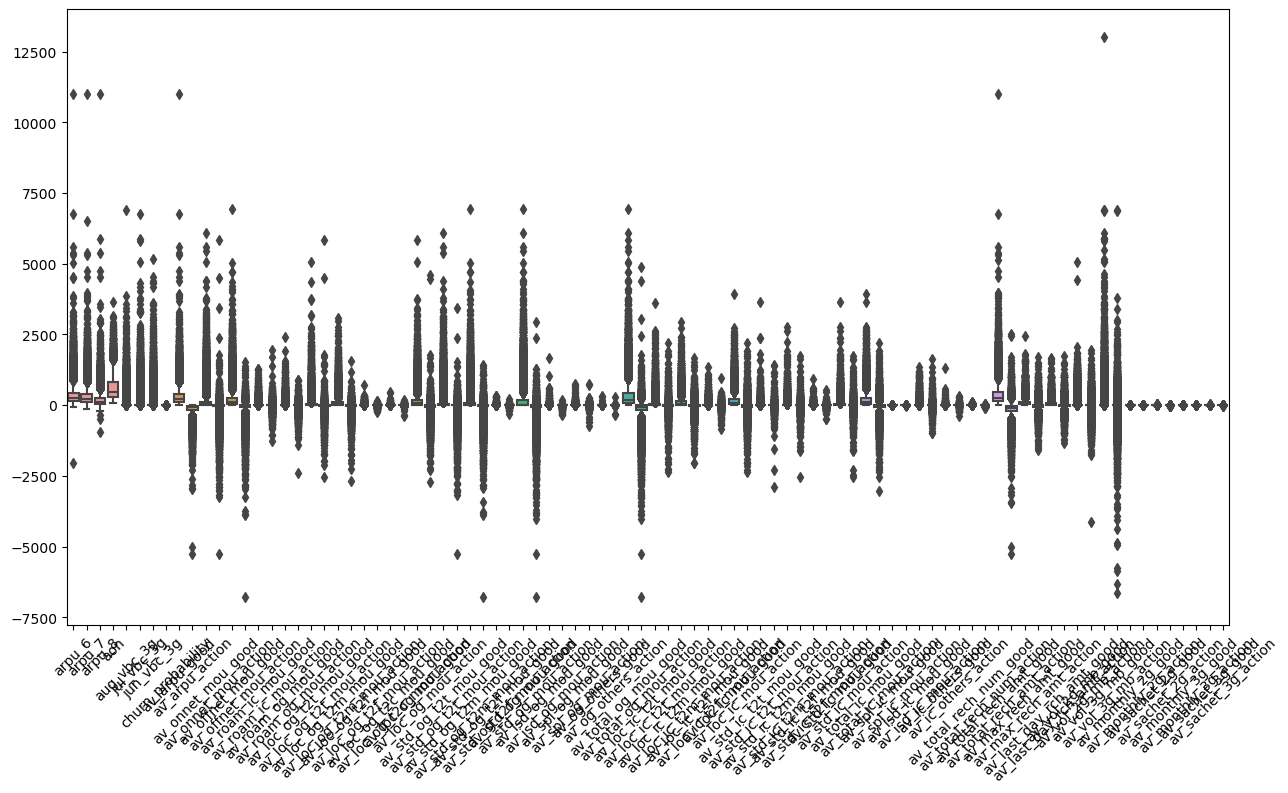

In [151]:
df_train_Outlier = df_train.drop('id',axis=1)
#df_train_Outlier.info()
df_train_Outlier = df_train_Outlier.apply(cap_outliers, axis=1)
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(df_train_Outlier)

In [152]:
# Assuming 'df' is your DataFrame
df_train.set_index('id', inplace=True)

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [153]:


X = df_train.drop(['churn_probability'],axis=1).iloc[:,:-1]
y = df_train['churn_probability']

X.shape, y.shape

((36740, 86), (36740,))

In [154]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36740 entries, 0 to 69997
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   arpu_6                      36740 non-null  float64
 1   arpu_7                      36740 non-null  float64
 2   arpu_8                      36740 non-null  float64
 3   aon                         36740 non-null  int64  
 4   aug_vbc_3g                  36740 non-null  float64
 5   jul_vbc_3g                  36740 non-null  float64
 6   jun_vbc_3g                  36740 non-null  float64
 7   av_arpu_good                36740 non-null  float64
 8   av_arpu_action              36740 non-null  float64
 9   av_onnet_mou_good           36740 non-null  float64
 10  av_onnet_mou_action         36740 non-null  float64
 11  av_offnet_mou_good          36740 non-null  float64
 12  av_offnet_mou_action        36740 non-null  float64
 13  av_roam_ic_mou_good         36740 no

In [155]:
y.info()

<class 'pandas.core.series.Series'>
Index: 36740 entries, 0 to 69997
Series name: churn_probability
Non-Null Count  Dtype
--------------  -----
36740 non-null  int64
dtypes: int64(1)
memory usage: 574.1 KB


Splitting train and test data to avoid any contamination of the test data

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29392, 86), (7348, 86), (29392,), (7348,))

In [157]:
X_train.head()

,arpu_6,arpu_7,arpu_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,av_arpu_good,av_arpu_action,av_onnet_mou_good,...,av_vol_2g_mb_action,av_vol_3g_mb_good,av_vol_3g_mb_action,av_monthly_2g_good,av_monthly_2g_action,av_sachet_2g_good,av_sachet_2g_action,av_monthly_3g_good,av_monthly_3g_action,av_sachet_3g_good
id,,,,,,,,,,,,,,,,,,,,,
39499,28.700,195.217,91.796,3523,0.00,0.00,0.0,111.9585,-20.1625,136.035,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9000,267.770,159.402,190.087,2510,0.00,0.00,0.0,213.5860,-23.4990,16.845,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11828,68.736,153.099,1.800,272,0.00,0.00,0.0,110.9175,-109.1175,0.000,...,-0.175,253.155,-253.155,0.0,0.0,0.0,0.0,0.0,0.0,2.0
22691,112.121,313.777,66.322,1128,0.00,0.00,0.0,212.9490,-146.6270,140.810,...,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20703,452.217,463.990,247.558,3303,28.89,192.96,95.6,458.1035,-210.5455,72.775,...,-9.375,355.890,-355.890,1.0,-1.0,0.5,-0.5,0.0,0.0,0.0


In [158]:
##### Importing stats model
import statsmodels.api as sm

In [159]:
# Instantiate the model
# Adding the constant to X_train
log_no_pca = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [160]:
# Fit the model
log_no_pca = log_no_pca.fit().summary()

In [161]:
# Summary
log_no_pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                29392
Model:                            GLM   Df Residuals:                    29307
Model Family:                Binomial   Df Model:                           84
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7636.2
Date:                Sun, 20 Oct 2024   Deviance:                       15272.
Time:                        20:42:33   Pearson chi2:                 1.04e+08
No. Iterations:                    27   Pseudo R-squ. (CS):             0.3025
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2264      0.058      3.896      0.000       0.112       0.340
arpu_6                         0.0003      0.000      2.109      0.035    2.24e-05       0.001
arpu_7                         0.0008      0.000      4.934      0.000       0.000       0.001
arpu_8                        -0.0009      0.000     -3.102      0.002      -0.001      -0.000
aon                           -0.0002   2.91e-05     -7.193      0.000      -0.000      -0.000
aug_vbc_3g                    -0.0002      0.000     -1.227      0.220      -0.001       0.000
jul_vbc_3g                     0.0001      0.000      0.908      0.364      -0.000       0.000
jun_vbc_3g                     0.0002      0.000      1.752      0.080   -2.67e-05       0.000
av_arpu_good                   0.0006      0.000      4.317      0.000       0.000       0.001
av_arpu_action                -0.0014      0.000     -6.082      0.000      -0.002      -0.001
av_onnet_mou_good              0.0005      0.007      0.071      0.943      -0.013       0.014
av_onnet_mou_action            0.0073      0.007      1.053      0.292      -0.006       0.021
av_offnet_mou_good            -0.0012      0.007     -0.179      0.858      -0.015       0.012
av_offnet_mou_action           0.0069      0.007      1.025      0.305      -0.006       0.020
av_roam_ic_mou_good            0.0023      0.001      3.829      0.000       0.001       0.003
av_roam_ic_mou_action          0.0005      0.001      0.781      0.435      -0.001       0.002
av_roam_og_mou_good            0.0032      0.007      0.474      0.635      -0.010       0.017
av_roam_og_mou_action         -0.0028      0.007     -0.414      0.679      -0.016       0.010
av_loc_og_t2t_mou_good        62.3114      6.682      9.325      0.000      49.214      75.409
av_loc_og_t2t_mou_action      29.5703      5.188      5.700      0.000      19.402      39.738
av_loc_og_t2m_mou_good        62.3133      6.683      9.325      0.000      49.216      75.411
av_loc_og_t2m_mou_action      29.5727      5.188      5.700      0.000      19.405      39.741
av_loc_og_t2f_mou_good        62.3270      6.683      9.326      0.000      49.229      75.425
av_loc_og_t2f_mou_action      29.5892      5.188      5.703      0.000      19.420      39.758
av_loc_og_t2c_mou_good         0.0049      0.006      0.868      0.385      -0.006       0.016
av_loc_og_t2c_mou_action       0.0054      0.006      0.910      0.363      -0.006       0.017
av_loc_og_mou_good           -62.3127      6.683     -9.325      0.000     -75.410     -49.215
av_loc_og_mou_action         -29.5765      5.188     -5.701      0.000     -39.745     -19.408
av_std_og_t2t_mou_good       -12.0073      8.822     -1.361      0.173     -29.298       5.283
av_std_og_t2t_mou_action      -8.0537      

### Feature Selection Using RFE

In [162]:
# Importing logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
# Intantiate the logistic regression
logreg = LogisticRegression()

#### RFE with 15 columns

In [163]:
# Importing RFE
from sklearn.feature_selection import RFE

# Intantiate RFE with 15 columns
rfe = RFE(estimator=logreg, n_features_to_select=15)

# Fit the rfe model with traestimator=in set
rfe = rfe.fit(X_train, y_train)

In [164]:
# RFE selected columns
rfe_cols = X_train.columns[rfe.support_]
print(rfe_cols)

Index(['av_isd_og_mou_good', 'av_spl_og_mou_action', 'av_og_others_action',
       'av_loc_ic_t2t_mou_action', 'av_loc_ic_t2m_mou_action',
       'av_loc_ic_mou_good', 'av_std_ic_t2t_mou_action',
       'av_std_ic_t2m_mou_action', 'av_std_ic_t2f_mou_good',
       'av_total_ic_mou_action', 'av_isd_ic_mou_action', 'av_ic_others_good',
       'av_last_day_rch_amt_good', 'av_last_day_rch_amt_action',
       'av_sachet_2g_good'],
      dtype='object')


### Model-1 with RFE selected columns

In [165]:
# Adding constant to X_train
X_train_sm_1 = sm.add_constant(X_train[rfe_cols])

#Instantiate the model
log_no_pca_1 = sm.GLM(y_train, X_train_sm_1, family=sm.families.Binomial())

# Fit the model
log_no_pca_1 = log_no_pca_1.fit()

log_no_pca_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                29392
Model:                            GLM   Df Residuals:                    29376
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8868.9
Date:                Sun, 20 Oct 2024   Deviance:                       17738.
Time:                        20:43:07   Pearson chi2:                 1.19e+15
No. Iterations:                     9   Pseudo R-squ. (CS):             0.2415
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.6005      0.029    -20.629      0.000      -0.658      -0.543
av_isd_og_mou_good             0.0084      0.002      3.598      0.000       0.004       0.013
av_spl_og_mou_action          -0.0043      0.001     -3.028      0.002      -0.007      -0.002
av_og_others_action            0.0768      0.023      3.335      0.001       0.032       0.122
av_loc_ic_t2t_mou_action       0.0077      0.001     11.169      0.000       0.006       0.009
av_loc_ic_t2m_mou_action       0.0076      0.001     11.560      0.000       0.006       0.009
av_loc_ic_mou_good            -0.0183      0.000    -39.127      0.000      -0.019      -0.017
av_std_ic_t2t_mou_action       0.0248      0.001     29.107      0.000       0.023       0.026
av_std_ic_t2m_mou_action       0.0266      0.001     35.644      0.000       0.025       0.028
av_std_ic_t2f_mou_good        -0.0278      0.003     -8.130      0.000      -0.035      -0.021
av_total_ic_mou_action        -0.0272      0.001    -41.023      0.000      -0.029      -0.026
av_isd_ic_mou_action           0.0260      0.001     26.878      0.000       0.024       0.028
av_ic_others_good             -0.0287      0.006     -4.500      0.000      -0.041      -0.016
av_last_day_rch_amt_good      -0.0115      0.001    -17.743      0.000      -0.013      -0.010
av_last_day_rch_amt_action    -0.0117      0.001    -19.474      0.000      -0.013      -0.011
av_sachet_2g_good             -0.0657      0.014     -4.688      0.000      -0.093      -0.038
==============================================================================================
"""

#### Checking VIFs

In [166]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [167]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,av_total_ic_mou_action,5.54
4,av_loc_ic_t2m_mou_action,2.61
3,av_loc_ic_t2t_mou_action,2.25
5,av_loc_ic_mou_good,1.60
7,av_std_ic_t2m_mou_action,1.54
12,av_last_day_rch_amt_good,1.53
6,av_std_ic_t2t_mou_action,1.26
10,av_isd_ic_mou_action,1.26
13,av_last_day_rch_amt_action,1.20
0,av_isd_og_mou_good,1.04


##### Removing column og_others_8, which is insignificatnt as it has the highest p-value 0.99

In [169]:
# Removing av_total_ic_mou_action column 
log_cols = rfe_cols.to_list()
log_cols.remove('av_total_ic_mou_action')
print(log_cols)

['av_isd_og_mou_good', 'av_spl_og_mou_action', 'av_og_others_action', 'av_loc_ic_t2t_mou_action', 'av_loc_ic_t2m_mou_action', 'av_loc_ic_mou_good', 'av_std_ic_t2t_mou_action', 'av_std_ic_t2m_mou_action', 'av_std_ic_t2f_mou_good', 'av_isd_ic_mou_action', 'av_ic_others_good', 'av_last_day_rch_amt_good', 'av_last_day_rch_amt_action', 'av_sachet_2g_good']


### Model-2


In [170]:
# Adding constant to X_train
X_train_sm_2 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_2 = sm.GLM(y_train, X_train_sm_2, family=sm.families.Binomial())

# Fit the model
log_no_pca_2 = log_no_pca_2.fit()

log_no_pca_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                29392
Model:                            GLM   Df Residuals:                    29377
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10852.
Date:                Sun, 20 Oct 2024   Deviance:                       21705.
Time:                        20:43:59   Pearson chi2:                 7.45e+10
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1319
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.6056      0.027    -22.691      0.000      -0.658      -0.553
av_isd_og_mou_good             0.0097      0.002      5.120      0.000       0.006       0.013
av_spl_og_mou_action          -0.0042      0.001     -3.154      0.002      -0.007      -0.002
av_og_others_action            0.1233      0.026      4.675      0.000       0.072       0.175
av_loc_ic_t2t_mou_action      -0.0067      0.000    -16.193      0.000      -0.008      -0.006
av_loc_ic_t2m_mou_action      -0.0065      0.000    -18.085      0.000      -0.007      -0.006
av_loc_ic_mou_good            -0.0063      0.000    -26.457      0.000      -0.007      -0.006
av_std_ic_t2t_mou_action      -0.0020      0.001     -3.449      0.001      -0.003      -0.001
av_std_ic_t2m_mou_action      -0.0008      0.000     -2.510      0.012      -0.001      -0.000
av_std_ic_t2f_mou_good        -0.0062      0.003     -2.219      0.027      -0.012      -0.001
av_isd_ic_mou_action          -0.0013      0.001     -2.181      0.029      -0.003      -0.000
av_ic_others_good             -0.0094      0.005     -1.804      0.071      -0.020       0.001
av_last_day_rch_amt_good      -0.0195      0.001    -27.167      0.000      -0.021      -0.018
av_last_day_rch_amt_action    -0.0192      0.001    -28.453      0.000      -0.020      -0.018
av_sachet_2g_good             -0.0814      0.013     -6.243      0.000      -0.107      -0.056
==============================================================================================
"""

#### Checking VIF for Model-2

In [171]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,av_loc_ic_mou_good,1.54
11,av_last_day_rch_amt_good,1.53
12,av_last_day_rch_amt_action,1.19
4,av_loc_ic_t2m_mou_action,1.13
3,av_loc_ic_t2t_mou_action,1.07
0,av_isd_og_mou_good,1.04
8,av_std_ic_t2f_mou_good,1.04
13,av_sachet_2g_good,1.03
1,av_spl_og_mou_action,1.01
2,av_og_others_action,1.01


Now from the model summary and the VIF list we can see that all the variables are significant and there is no multicollinearity among the variables.

 we can conclused that ***Model-2 log_no_pca_2 will be the final model***.

###  Model performance on the train set

In [173]:
# Getting the predicted value on the train set
y_train_pred_no_pca = log_no_pca_2.predict(X_train_sm_2)
y_train_pred_no_pca.head()

id
39499    0.063265
9000     0.003426
11828    0.345667
22691    0.018196
20703    0.011506
dtype: float64

##### Creating a dataframe with the actual churn and the predicted probabilities

In [174]:
y_train_pred_final = pd.DataFrame({'churn':y_train.values, 'churn_prob':y_train_pred_no_pca.values})

#Assigning Customer ID for each record for better readblity
#CustID is the index of each record.
y_train_pred_final['CustID'] = y_train_pred_final.index

y_train_pred_final.head()

,churn,churn_prob,CustID
0,0,0.063265,0
1,0,0.003426,1
2,0,0.345667,2
3,0,0.018196,3
4,0,0.011506,4


##### Finding Optimal Probablity Cutoff Point

In [175]:
# Creating columns for different probablity cutoffs
prob_cutoff = [float(p/10) for p in range(10)]

for i in prob_cutoff:
    y_train_pred_final[i] = y_train_pred_final['churn_prob'].map(lambda x : 1 if x > i else 0)
    
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.063265,0,1,0,0,0,0,0,0,0,0,0
1,0,0.003426,1,1,0,0,0,0,0,0,0,0,0
2,0,0.345667,2,1,1,1,1,0,0,0,0,0,0
3,0,0.018196,3,1,0,0,0,0,0,0,0,0,0
4,0,0.011506,4,1,0,0,0,0,0,0,0,0,0


##### Now let's calculate the accuracy sensitivity and specificity for various probability cutoffs.

In [176]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [177]:
from sklearn import metrics
import pandas as pd

# Assuming cutoff_df is already defined
cutoff_df = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in prob_cutoff:
    cm1 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final[i])
    total1 = sum(sum(cm1))
    accuracy = (cm1[0, 0] + cm1[1, 1]) / total1
    speci = cm1[0, 0] / (cm1[0, 0] + cm1[0, 1])
    sensi = cm1[1, 1] / (cm1[1, 0] + cm1[1, 1])
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]

print(cutoff_df)
    

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.160180     1.000000     0.000000
0.1          0.1  0.539705     0.907392     0.469575
0.2          0.2  0.705940     0.813509     0.685424
0.3          0.3  0.823421     0.622770     0.861692
0.4          0.4  0.839174     0.011682     0.997002
0.5          0.5  0.839684     0.003611     0.999149
0.6          0.6  0.839854     0.001699     0.999716
0.7          0.7  0.839854     0.001062     0.999838
0.8          0.8  0.839854     0.000850     0.999878
0.9          0.9  0.839888     0.000850     0.999919


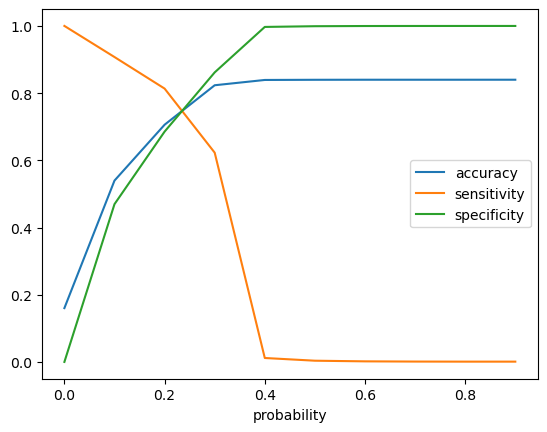

In [179]:
# Plotting accuracy, sensitivity and specificity for different probabilities.
cutoff_df.plot('probability', ['accuracy','sensitivity','specificity'])
plt.show()

##### Analysis of the above curve
Accuracy - Becomes stable around 0.4

Sensitivity - Decreases with the increased probablity.

Specificity - Increases with the increasing probablity.

`At point 0.25` where the three parameters cut each other, we can see that there is a balance bethween sensitivity and specificity with a good accuracy.

Here we are intended to acheive better sensitivity than accuracy and specificity. Though as per the above curve, we should take 0.25 as the optimum probability cutoff, we are taking ***0.2*** for acheiving higher sensitivity, which is our main goal.

In [180]:
# Creating a column with name "predicted", which is the predicted value for 0.5 cutoff 
y_train_pred_final['predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.2 else 0)
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.063265,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.003426,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0.345667,2,1,1,1,1,0,0,0,0,0,0,1
3,0,0.018196,3,1,0,0,0,0,0,0,0,0,0,0
4,0,0.011506,4,1,0,0,0,0,0,0,0,0,0,0


##### Metrics

In [181]:
# Confusion metrics
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['predicted'])
print(confusion)

[[16919  7765]
 [  878  3830]]


In [182]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [183]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.705940391943386
Sensitivity:- 0.8135089209855565
Specificity:- 0.6854237562793712


We have got good accuracy, sensitivity and specificity on the train set prediction.

##### Plotting the ROC Curve (Trade off between sensitivity & specificity)

In [184]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

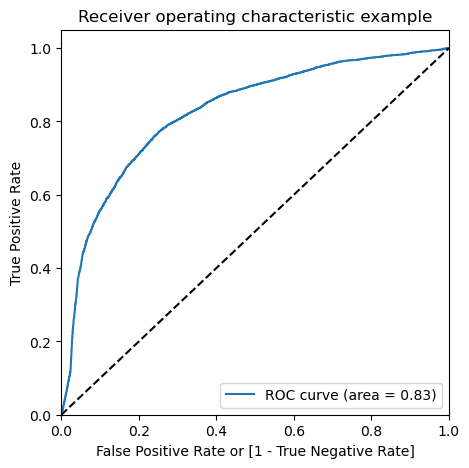

In [185]:
draw_roc(y_train_pred_final['churn'], y_train_pred_final['churn_prob'])

We can see the area of the ROC curve is closer to 1, whic is the Gini of the model.

### Testing the model on the test set

In [186]:
# Taking a copy of the test set
X_test_log = X_test.copy()

In [187]:
# Taking only the columns, which are selected in the train set after removing insignificant and multicollinear variables
X_test_log = X_test_log[log_cols]

In [188]:
# Adding constant on the test set
X_test_sm = sm.add_constant(X_test_log)

##### Predictions on the test set with final model

In [189]:
# Predict on the test set
y_test_pred = log_no_pca_2.predict(X_test_sm)

In [190]:
y_test_pred.head()

id
23788    0.120545
1444     0.087384
8063     0.285018
55854    0.003384
31028    0.310066
dtype: float64

In [191]:
# Converting y_test_pred to a dataframe because y_test_pred is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
id,
23788,0.120545
1444,0.087384
8063,0.285018
55854,0.003384
31028,0.310066


In [192]:
# Convetting y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn_probability
id,
23788,0
1444,0
8063,1
55854,0
31028,1


In [193]:
# Putting index to Customer ID 
y_test_df['CustID'] = y_test_df.index

In [194]:
# Removing index form the both dataframes for merging them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [195]:
# Appending y_pred_1 and y_test_df
y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

In [196]:
y_test_pred_final.head()

,churn_probability,CustID,0
0,0,23788,0.120545
1,0,1444,0.087384
2,1,8063,0.285018
3,0,55854,0.003384
4,1,31028,0.310066


In [197]:
# Renaming the '0' column as churn probablity
y_test_pred_final = y_test_pred_final.rename(columns={0:'churn_prob'})

In [198]:
y_test_pred_final.head()

,churn_probability,CustID,churn_prob
0,0,23788,0.120545
1,0,1444,0.087384
2,1,8063,0.285018
3,0,55854,0.003384
4,1,31028,0.310066


In [199]:
y_test_pred_final.head()

,churn_probability,CustID,churn_prob
0,0,23788,0.120545
1,0,1444,0.087384
2,1,8063,0.285018
3,0,55854,0.003384
4,1,31028,0.310066


In [200]:
# In the test set using probablity cutoff 0.5, what we got in the train set 
y_test_pred_final['test_predicted'] = y_test_pred_final['churn_prob'].map(lambda x: 1 if x > 0.2 else 0)

In [201]:
y_test_pred_final.head()

,churn_probability,CustID,churn_prob,test_predicted
0,0,23788,0.120545,0
1,0,1444,0.087384,0
2,1,8063,0.285018,1
3,0,55854,0.003384,0
4,1,31028,0.310066,1


##### Metrics

In [202]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test_pred_final['churn_probability'], y_test_pred_final['test_predicted'])
print(confusion)

[[4256 1944]
 [ 214  934]]


In [203]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [204]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test_pred_final['churn_probability'], y_test_pred_final['test_predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.706314643440392
Sensitivity:- 0.813588850174216
Specificity:- 0.6864516129032258


## Business recomendation

#### Plots of important predictors for churn and non churn customers

In [222]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29392 entries, 39499 to 24320
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   arpu_6                      29392 non-null  float64
 1   arpu_7                      29392 non-null  float64
 2   arpu_8                      29392 non-null  float64
 3   aon                         29392 non-null  int64  
 4   aug_vbc_3g                  29392 non-null  float64
 5   jul_vbc_3g                  29392 non-null  float64
 6   jun_vbc_3g                  29392 non-null  float64
 7   av_arpu_good                29392 non-null  float64
 8   av_arpu_action              29392 non-null  float64
 9   av_onnet_mou_good           29392 non-null  float64
 10  av_onnet_mou_action         29392 non-null  float64
 11  av_offnet_mou_good          29392 non-null  float64
 12  av_offnet_mou_action        29392 non-null  float64
 13  av_roam_ic_mou_good         2939

In [223]:
# Creating churn dataframe
data_churn = data[data['churn_probability'] == 1]
# Creating not churn dataframe
data_non_churn = data[data['churn_probability'] == 0]

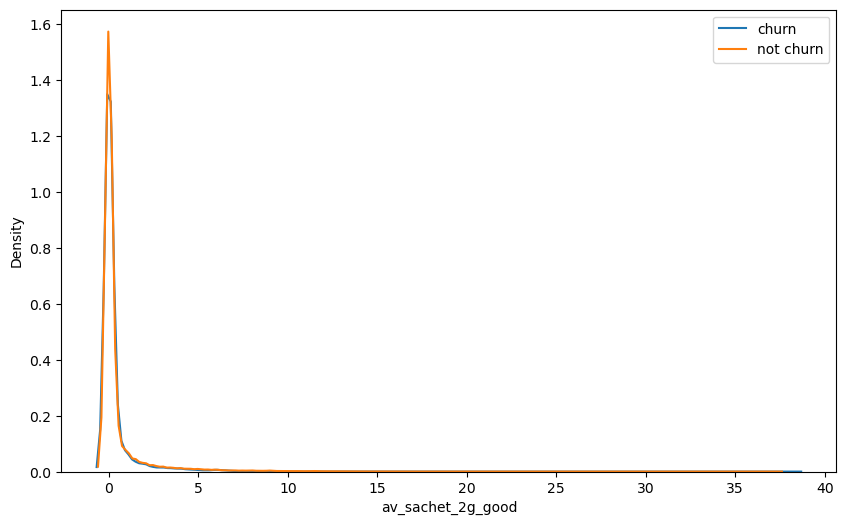

In [224]:
# Plotting loc_ic_mou_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['av_sachet_2g_good'],label='churn',hist=False)
sns.distplot(data_non_churn['av_sachet_2g_good'],label='not churn',hist=False)
plt.legend()
plt.show()

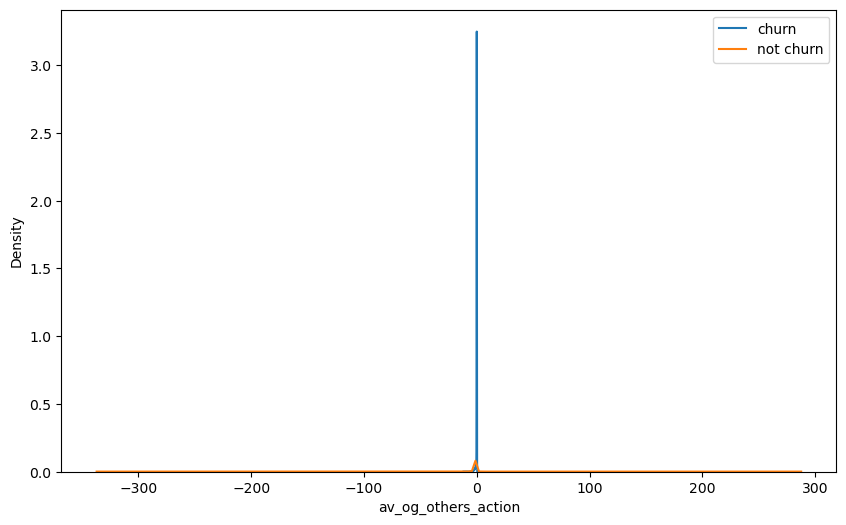

In [226]:
# Plotting isd_og_mou_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['av_og_others_action'],label='churn',hist=False)
sns.distplot(data_non_churn['av_og_others_action'],label='not churn',hist=False)
plt.legend()
plt.show()

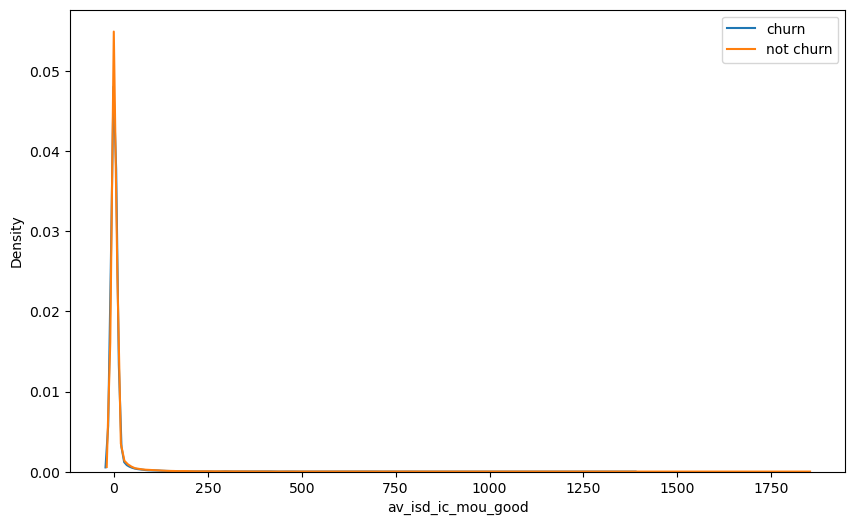

In [229]:
# Plotting monthly_3g_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['av_isd_ic_mou_good'],label='churn',hist=False)
sns.distplot(data_non_churn['av_isd_ic_mou_good'],label='not churn',hist=False)
plt.legend()
plt.show()